In [2]:
import numpy as np
import math
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat
from pdf2image import convert_from_path

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

#from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json

from keras.models import load_model

In [ ]:
# Converting pdf images from a folder to jpg images and save in different folder :

"""
    pdf directory = drg_21_8_pdf
    jpg directory = drg_21_8_jpg
    
"""

drg_directory = '/home/scar3crow/Downloads/21-8-pdf'   
                                                        
drg_new_image = ['/home/scar3crow/Downloads/21-8-pdf/{}'.format(i) for i in os.listdir(drg_directory)] # making the list
drg_new_image.sort() # Sorting the list


for i in range(len(drg_new_image)):
    
    pages = convert_from_path(drg_new_image[i], 300)
    

    drg_new_image_split = drg_new_image[i].split("/")
    drg_new_image_split = drg_new_image_split[-1].split(".")
    
    
    image_number = drg_new_image_split[0]
    
    for page in pages:
        
        i_path = '/home/scar3crow/Downloads/drg_21_8_jpg/' + image_number
    
        page.save(i_path, 'JPEG')


In [4]:
# Converting pdf images from a folder to jpg images and save in different folder, drg. file names are assigned here :

"""
    pdf directory = drg_21_8_pdf
    jpg directory = drg_21_8_jpg
    
"""

drg_directory = '/home/scar3crow/Downloads/drg_all_new'   
                                                        
drg_new_image = ['/home/scar3crow/Downloads/drg_all_new/{}'.format(i) for i in os.listdir(drg_directory)] # making the list
drg_new_image.sort() # Sorting the list
img_number = 1187


for i in range(len(drg_new_image)):
    
    pages = convert_from_path(drg_new_image[i], 300)
    

#    drg_new_image_split = drg_new_image[i].split("/")
#    drg_new_image_split = drg_new_image_split[-1].split(".")
    
    img_number_1 = img_number + i
    
    image_number = str(img_number_1) + '.jpg'
    
    for page in pages:
        
        i_path = '/home/scar3crow/Downloads/drg_all_new_jpg/' + image_number
    
        page.save(i_path, 'JPEG')


In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

grid_size = [19, 19]
grid_y_axis = 19  # each image is to be segmented to 17 x 17 grid
grid_x_axis = 19  # # each image is to be segmented to 17 x 17 grid

grid_stride = target_w / grid_x_axis  # grid cell width
grid_stride = target_h / grid_y_axis  # grid cell height

channels = 3
num_anchors = 3
class_num = 1 # vendor, invoice, inv_date, po, buyer
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['item'] # details of classes

In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

grid_size_1 = [19, 19]
grid_y_axis_1 = 19  # each image is to be segmented to 17 x 17 grid
grid_x_axis_1 = 19  # # each image is to be segmented to 17 x 17 grid
grid_stride_1 = target_w / grid_x_axis_1  # grid cell width
grid_stride_1 = target_h / grid_y_axis_1  # grid cell height

grid_size_2 = [38, 38]
grid_y_axis_2 = 38  # each image is to be segmented to 17 x 17 grid
grid_x_axis_2 = 38  # # each image is to be segmented to 17 x 17 grid
grid_stride_2 = target_w / grid_x_axis_2  # grid cell width
grid_stride_2 = target_h / grid_y_axis_2  # grid cell height

grid_size_3 = [76, 76]
grid_y_axis_3 = 76  # each image is to be segmented to 17 x 17 grid
grid_x_axis_3 = 76  # # each image is to be segmented to 17 x 17 grid
grid_stride_3 = target_w / grid_x_axis_3  # grid cell width
grid_stride_3 = target_h / grid_y_axis_3  # grid cell height


channels = 3
num_anchors = 3
class_num = 1 # vendor, invoice, inv_date, po, buyer
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['item'] # details of classes

In [3]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    

    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [3]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/drg_all'   
                                                        
inv_new_image = ['/home/scar3crow/Downloads/drg_all/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_new_image.sort() # Sorting the list

num_images = len(inv_new_image)

print('Number of images = ', num_images)


Number of images =  462


In [4]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(inv_new_image)):
    image = cv2.imread(inv_new_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_new_image[i])
        
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.tail(3)

image_serial  rows  columns
459  /home/scar3crow/Downloads/drg_all/97.jpg  2479     3508
460  /home/scar3crow/Downloads/drg_all/98.jpg  2479     3508
461  /home/scar3crow/Downloads/drg_all/99.jpg  2479     3508

In [5]:
r_new_data_8 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_8.csv')

for i in range(len(r_new_data_8)):
    
    f_name = r_new_data_8['#filename'][i]
    idx = r_new_data_8.index[r_new_data_8['#filename'] == f_name]
    f_name_rev = str(f_name) + '.jpg'
    
    r_new_data_8.at[idx, '#filename'] = f_name_rev
    

In [35]:
r_new_data_8.head()

#filename  file_size file_attributes  region_count  region_id  \
0   601.jpg     915685              {}             1          0   
1   602.jpg     685837              {}             1          0   
2   603.jpg     589036              {}             1          0   
3   604.jpg     504187              {}             1          0   
4   605.jpg     547213              {}             1          0   

                             region_shape_attributes region_attributes  
0  {"name":"rect","x":2053,"y":1099,"width":1295,...   {"text":"item"}  
1  {"name":"rect","x":2145,"y":1649,"width":1205,...   {"text":"item"}  
2  {"name":"rect","x":2143,"y":1808,"width":1208,...   {"text":"item"}  
3  {"name":"rect","x":2050,"y":1854,"width":1301,...   {"text":"item"}  
4  {"name":"rect","x":2275,"y":1765,"width":1076,...   {"text":"item"}

In [6]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_new_data = pd.DataFrame()

r_new_data_1 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_1.csv')
r_new_data_2 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_2.csv')
r_new_data_3 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_3.csv')
r_new_data_4 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_4.csv')
r_new_data_5 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_5.csv')
r_new_data_6 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_6.csv')
r_new_data_7 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_7.csv')
r_new_data_9 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_9.csv')
r_new_data_10 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_10.csv')

r_new_data = pd.concat([r_new_data_1, r_new_data_2, r_new_data_3, r_new_data_4, r_new_data_5, r_new_data_6, r_new_data_7, r_new_data_8, r_new_data_9, r_new_data_10], axis = 0, ignore_index = True)

num_obj = r_new_data['region_count'][0] # number of objects in each photo
r_new_data.drop(r_new_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data = r_new_data[(r_new_data['#filename'] != '33.jpg') & (r_new_data['#filename'] != '20.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '74.jpg') & (r_new_data['#filename'] != '42.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '96.jpg') & (r_new_data['#filename'] != '28.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '47.jpg') & (r_new_data['#filename'] != '122.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '63.jpg') & (r_new_data['#filename'] != '97.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '56.jpg') & (r_new_data['#filename'] != '38.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '36.jpg') & (r_new_data['#filename'] != '309.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '314.jpg') & (r_new_data['#filename'] != '317.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '318.jpg') & (r_new_data['#filename'] != '324.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '330.jpg') & (r_new_data['#filename'] != '331.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '525.jpg') & (r_new_data['#filename'] != '322.jpg')].reset_index(drop=True)

r_new_data.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_new_data["#filename"].nunique() # Find out number of unique images

print('Number of unique images = ', num_images)
r_new_data.head(5)

Number of unique images =  431


#filename                            region_shape_attributes  \
0     1.jpg  {"name":"rect","x":1886,"y":1863,"width":1457,...   
1     2.jpg  {"name":"rect","x":2230,"y":1615,"width":1243,...   
2     3.jpg  {"name":"rect","x":2143,"y":1855,"width":1200,...   
3     4.jpg  {"name":"rect","x":2071,"y":1840,"width":1393,...   
4     5.jpg  {"name":"rect","x":2224,"y":1330,"width":1140,...   

  region_attributes  
0   {"text":"item"}  
1   {"text":"item"}  
2   {"text":"item"}  
3   {"text":"item"}  
4   {"text":"item"}

In [7]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_new_data)):
    
    r_size = r_new_data.values[i, 1][1:(len(r_new_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_new_data.values[i, 2][1:(len(r_new_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_new_data['#filename'][i]

    i_path = '/home/scar3crow/Downloads/drg_all/' + foto_id
    foto_index = int(df_new[df_new['image_serial'] == i_path].index[0])
    foto_width = df_new['columns'][foto_index]
    foto_height = df_new['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_new_data.insert(loc=1, column='img_idx', value=img_index_values)
r_new_data.insert(loc=2, column='i_path', value=img_path_values)
r_new_data.insert(loc=3, column='x', value=x_values)
r_new_data.insert(loc=4, column='y', value=y_values)
r_new_data.insert(loc=5, column='width', value=width_values)
r_new_data.insert(loc=6, column='height', value=height_values)
r_new_data.insert(loc=7, column='obj_class', value=class_values)
r_new_data.insert(loc=8, column='img_wd', value=i_width_values)
r_new_data.insert(loc=9, column='img_ht', value=i_height_values)

r_new_data.drop(r_new_data.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_new_data[0:3]


img_id  img_idx                                   i_path     x     y  width  \
0  1.jpg        0  /home/scar3crow/Downloads/drg_all/1.jpg  1886  1863   1457   
1  2.jpg       71  /home/scar3crow/Downloads/drg_all/2.jpg  2230  1615   1243   
2  3.jpg      230  /home/scar3crow/Downloads/drg_all/3.jpg  2143  1855   1200   

   height obj_class  img_wd  img_ht  
0     107      item    3509    2480  
1     410      item    3509    2480  
2     115      item    3509    2480

In [8]:
## Find out image with max boxes - to check whether annotation is correct :

max_box_image = r_new_data['img_id'].value_counts().max()
image_with_max_box =  r_new_data['img_id'].value_counts().idxmax()
print(image_with_max_box, 'with', max_box_image, 'boxes')

622.jpg with 1 boxes


In [9]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [10]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0
for i in range(num_images):
    image_line = []
    
    img = r_new_data['img_id'][limit_upper]
    kount = r_new_data['img_id'].value_counts()[img]
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_new_data[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)
    image_line.append(pic_path)
    image_line.append(boxes)
    image_line.append(labels)
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[3])   ##  boxes are in format xmin, ymin, xmax, ymax

431
[282, '/home/scar3crow/Downloads/drg_all/4.jpg', array([[2071., 1840., 3464., 2056.]], dtype=float32), array([0]), 3509, 2480]


In [40]:
img_id = 10
image_id = str(img_id) + '.jpg'
image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
idx_crop = [i for i in range(len(all_image_line)) if all_image_line[i][1] == image_path]
idx_crop[0]

9

In [11]:
all_image_line[300][1]

'/home/scar3crow/Downloads/drg_all/643.jpg'

In [14]:
all_image_line

[[0,
  '/home/scar3crow/Downloads/drg_all/1.jpg',
  array([[1886., 1863., 3343., 1970.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [71,
  '/home/scar3crow/Downloads/drg_all/2.jpg',
  array([[2230., 1615., 3473., 2025.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [152,
  '/home/scar3crow/Downloads/drg_all/3.jpg',
  array([[2143., 1855., 3343., 1970.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [204,
  '/home/scar3crow/Downloads/drg_all/4.jpg',
  array([[2071., 1840., 3464., 2056.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [215,
  '/home/scar3crow/Downloads/drg_all/5.jpg',
  array([[2224., 1330., 3364., 2104.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [275,
  '/home/scar3crow/Downloads/drg_all/6.jpg',
  array([[1893., 1800., 3347., 1969.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [352,
  '/home/scar3crow/Downloads/drg_all/7.jpg',
  array([[2334., 1884., 3468., 2057.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [363,
  '/home/scar3crow/Down

In [11]:
## Draw Box with sharpened image :

def draw_box_pred(img_id, box_list, label, target_size):
    
    image_id = str(img_id) + '.jpg'
#    print(image_id)
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
#    print(image_path)

# find index of image in data frame :
    """
    image_list = r_new_data['img_id'].unique() # make a list of unique images
    idx = [i for i in range(len(image_list)) if image_list[i] == image_id] # find index of image
    """
# reading image and resizing as per target image :

    x = cv2.imread(image_path)
    x_ratio = target_size[1] / x.shape[1]
    y_ratio = target_size[0] / x.shape[0]

    xx = cv2.resize(x, (target_size[1], target_size[0]))
#    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#    xx = cv2.filter2D(xx, -1, kernel)
#    xx = unsharp_mask(xx)
    """
    print('======================', xx.max())
    print('======================', xx.min())
    
# slicing as per current image id

    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[idx[0]]])].reset_index(drop=True) 

    m = int(target_size[1] / grid_size[1])  # making x-scale for making grid
    n = int(target_size[0] / grid_size[0])  # making x-scale for making grid

    x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15, m*16, m*17, m*18] 
    y_range = [0, n*1, n*2, n*3, n*4, n*5, n*6, n*7, n*8, n*9, n*10, n*11, n*12, n*13, n*14, n*15, n*16, n*17, n*18 ]

    for i in x_range:
            for j in y_range:
                cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)
            
    for j in range(len(r_new_data_slice)):
    """
    for j in range(len(box_list)):
        
        xmin = int(box_list[j][0])
        ymin = int(box_list[j][1])
    
        xxmin = int(xmin * x_ratio)
        yymin = int(ymin * y_ratio)
 
        xmax = int(box_list[j][2])
        ymax = int(box_list[j][3])
    
        xxmax = int(xmax * x_ratio)
        yymax = int(ymax * y_ratio)
        
        obj_class = categories[int(label[j])]
    
#        print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
        cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 0, 255), 2)
    
    
        cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
    x_pil = Image.fromarray(x)
#    display(x_pil)

    xx_pil = Image.fromarray(xx)
#    display(xx_pil)

    return(display(x_pil))   #, display(xx_pil))

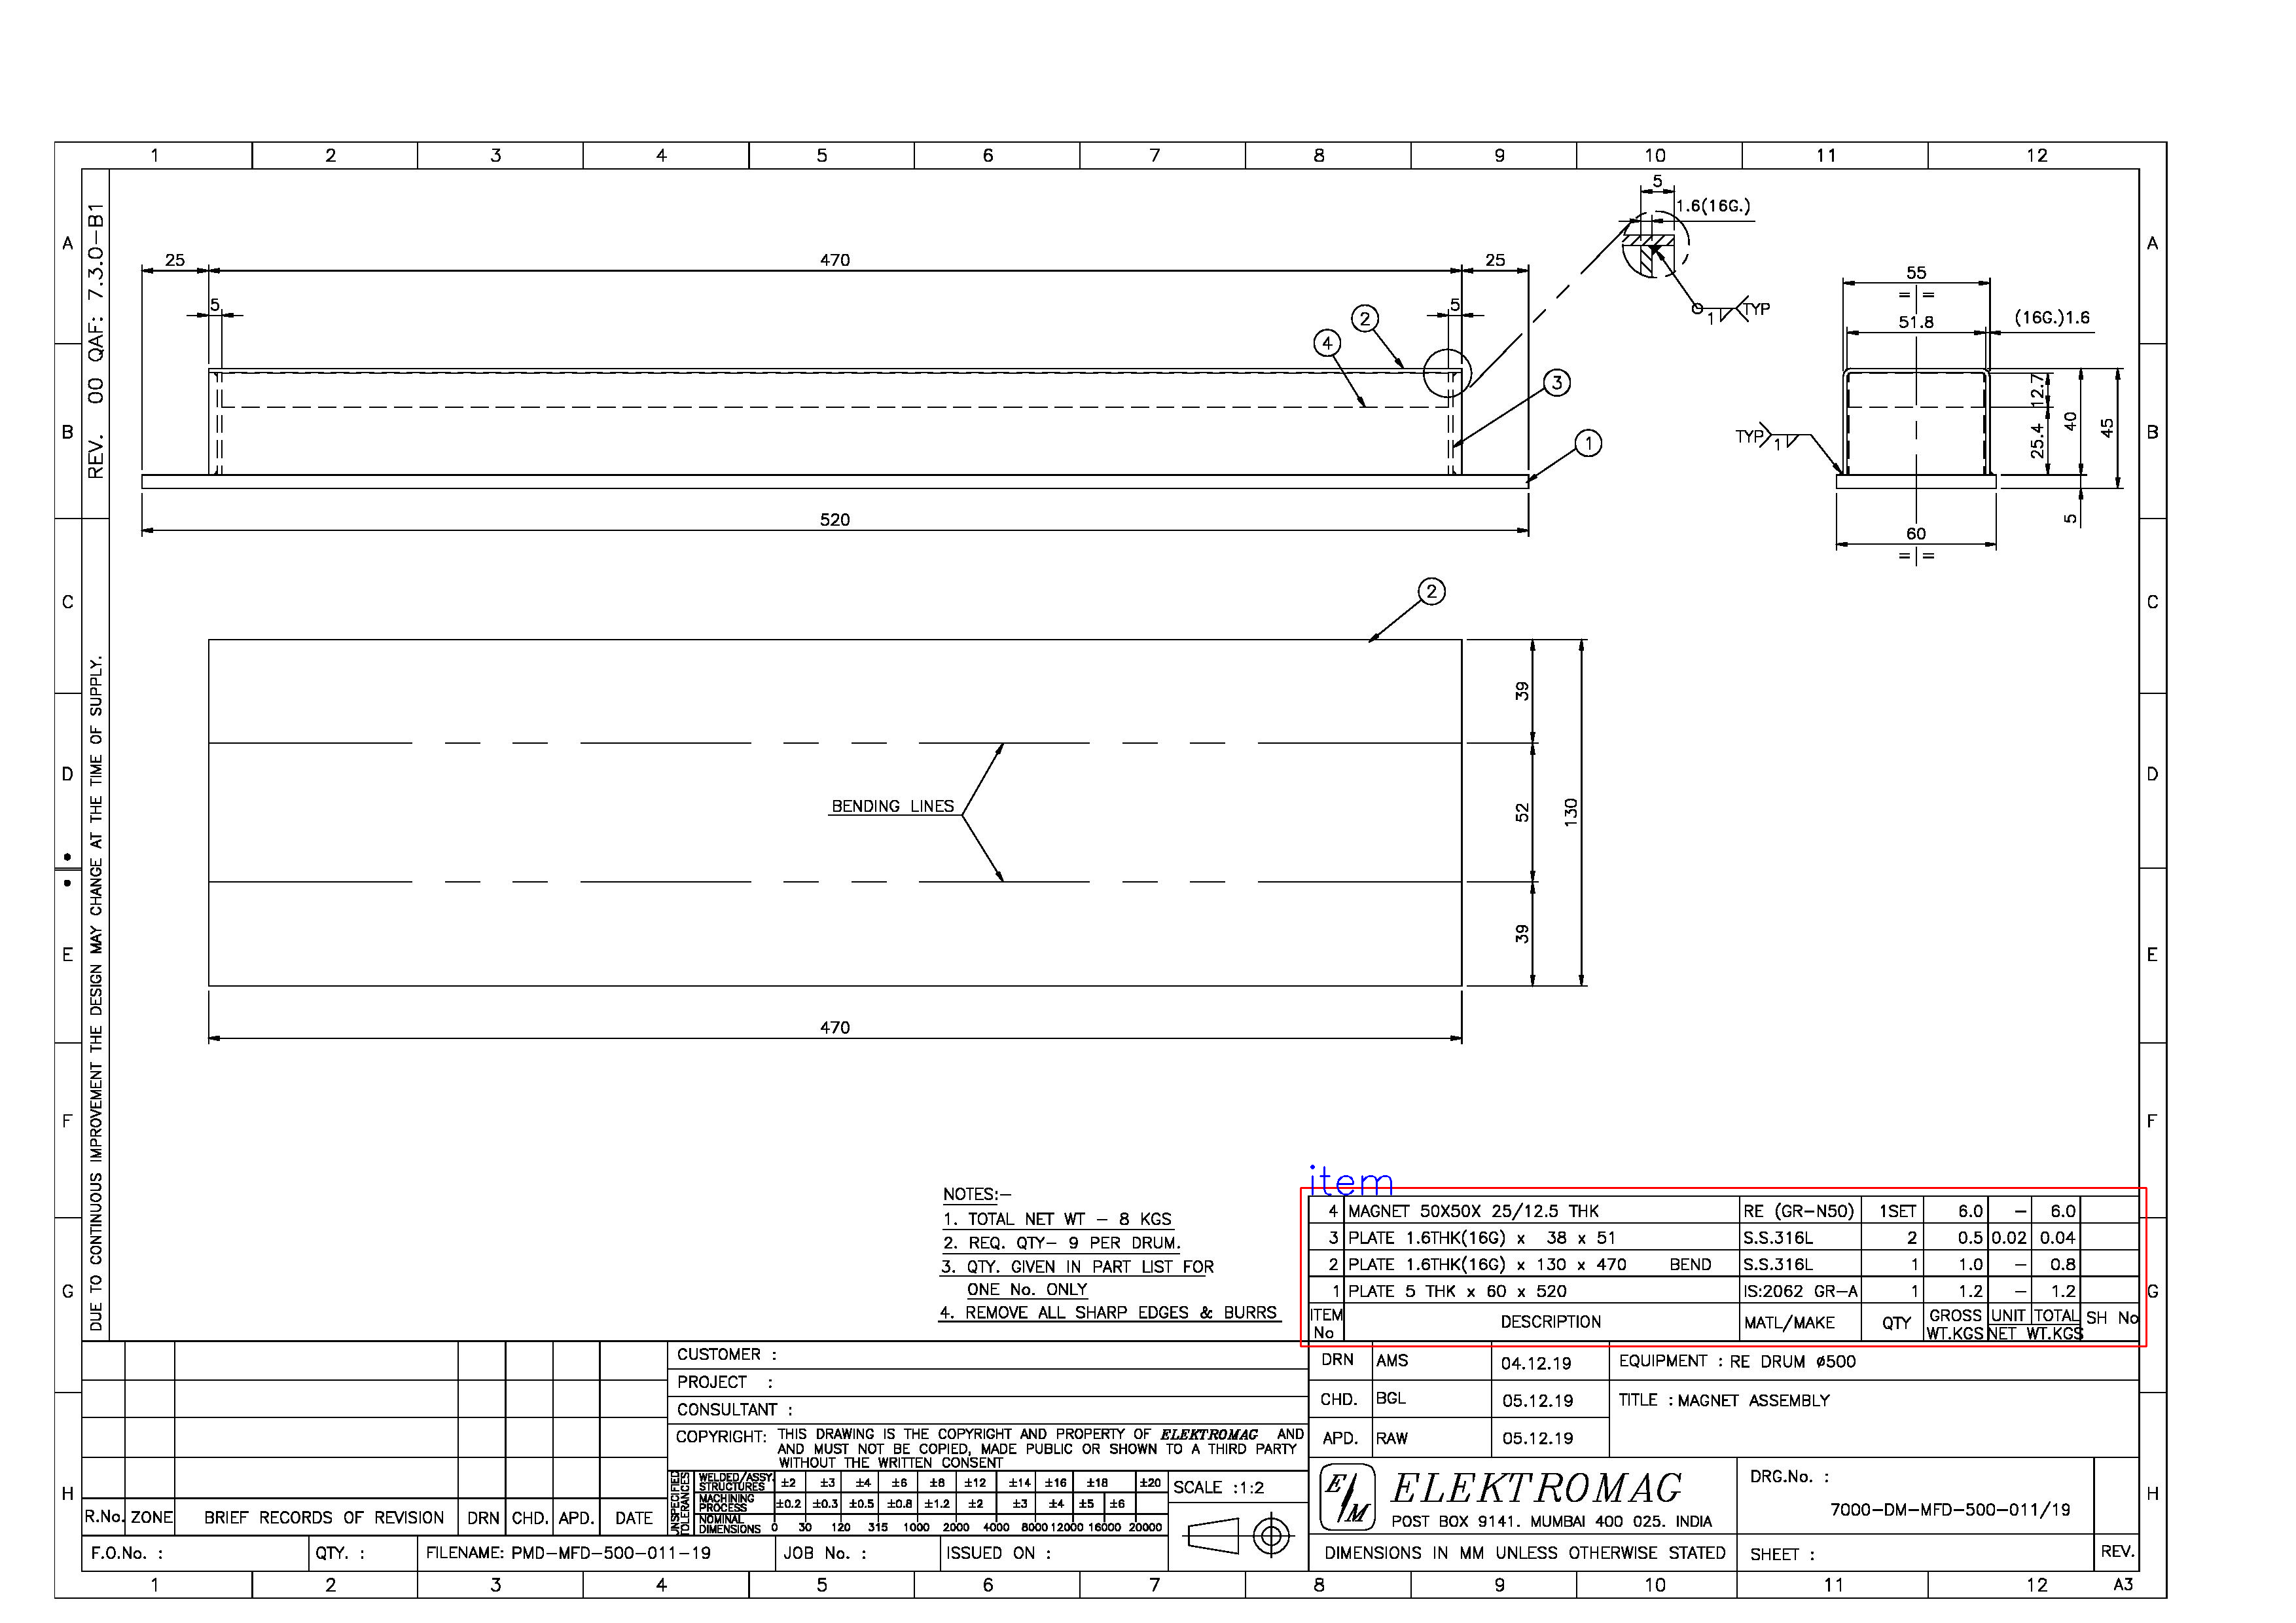

In [47]:
# Check whether box_list i.e. VGG image annotation is correct 

_,_,box_list,label,_,_ = all_image_line[300]

img_id = 643

draw_box_pred(img_id, box_list,label, target_size)


In [7]:
## Cropping the image or drawing to take out only the BOM area which is boxed :

def crop_bom(img_id):

    image_id = str(img_id) + '.jpg'
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id

    idx_crop = [i for i in range(len(all_image_line)) if all_image_line[i][1] == image_path] # find index of image       

    _,_,box_list,label,_,_ = all_image_line[idx_crop[0]]

    # print(box_list)  ## box_list is in format xmin, ymin, xmax, ymax

    x = cv2.imread(image_path)

    # By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
    # we need to convert from BGR to RGB format/mode:
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    
    # xx = unsharp_mask(x)
    
    xx_gray_list = []
    
    for i in range(len(box_list)):

        xx = x[int(box_list[i][1]):int(box_list[i][3]), int(box_list[i][0]):int(box_list[i][2])]
        xx_gray = cv2.cvtColor(xx,cv2.COLOR_BGR2GRAY)
        xx_gray_list.append(xx_gray)

    return xx_gray_list  ## this list is for more than 1 BOM in same drawing
    


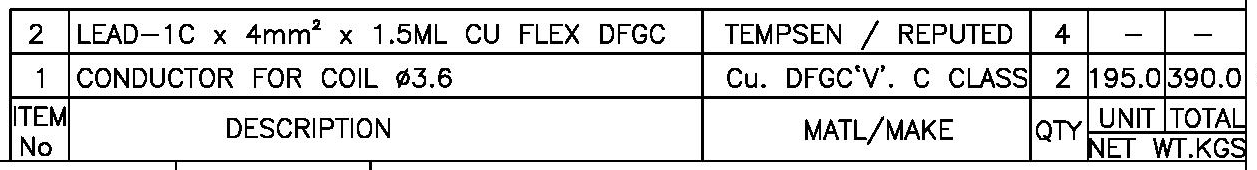

In [13]:
xx_gray_list = crop_bom(2047)

for i in range(len(xx_gray_list)):

    xx_pil = Image.fromarray(xx_gray_list[i])

    display(xx_pil)

In [8]:
## Find out all individual boxes for subsequent text extraction :

def all_boxes(img_id):
    
    xx_gray_list = crop_bom(img_id)
    
    boxes_list = []
    
    for i in range(len(xx_gray_list)):
    
        ##thresholding the image to a binary image
        thresh,img_bin = cv2.threshold(xx_gray_list[i],0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        #inverting the image 
        img_bin_invert = 255-img_bin

        img_pil = Image.fromarray(img_bin_invert)
        
        display(img_pil) 
        
        # Length(width) of kernel as 100th of total width
        kernel_len = xx_gray_list[i].shape[1]//100

        # Defining a vertical kernel to detect all vertical lines of image 
        ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

        # Defining a horizontal kernel to detect all horizontal lines of image
        hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

        #Use vertical kernel to detect and save the vertical lines in a jpg
        image_1 = cv2.erode(img_bin_invert, ver_kernel, iterations=3)
        vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

        #Use horizontal kernel to detect and save the horizontal lines in a jpg
        image_2 = cv2.erode(img_bin_invert, hor_kernel, iterations=3)
        horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

        # Combine horizontal and vertical lines in a new third image, with both having same weight.
        img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

        # A kernel of 2x2
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        # print('Final kernel = ', kernel)

        img_vh_d = cv2.dilate(img_vh, kernel, iterations=2)

        img_vh_d_pil = Image.fromarray(img_vh_d)
        
        display(img_vh_d_pil)
        
        # Defining the cell boxes

        contours, hierarchy = cv2.findContours(img_vh_d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        boxes = np.zeros((len(contours), 4))

        for i in range(len(contours)):
    
            cnt = contours[i]
            x, y, w, h = cv2.boundingRect(cnt)
            boxes[i, 0] = x
            boxes[i, 1] = y
            boxes[i, 2] = w
            boxes[i, 3] = h

        # print(len(boxes))
        
        boxes_list.append(boxes)
    
    return boxes_list      ## ## in format x, y, w, h


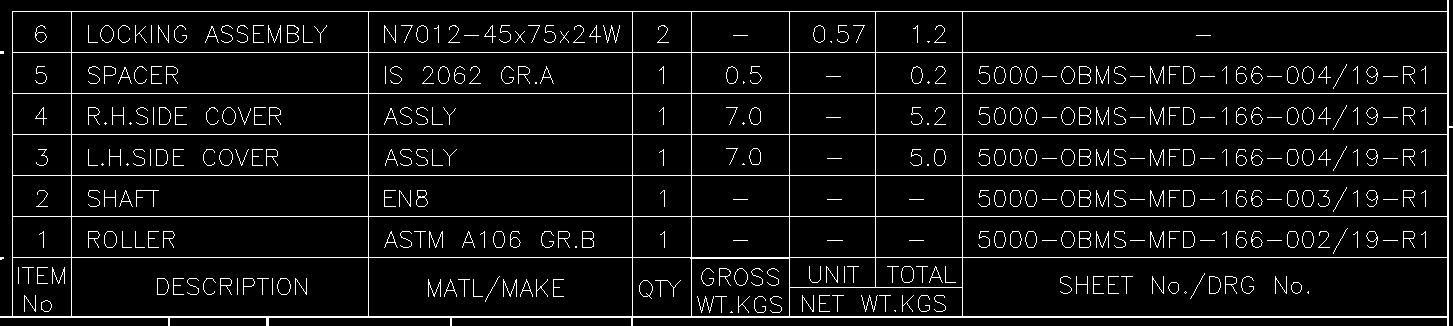

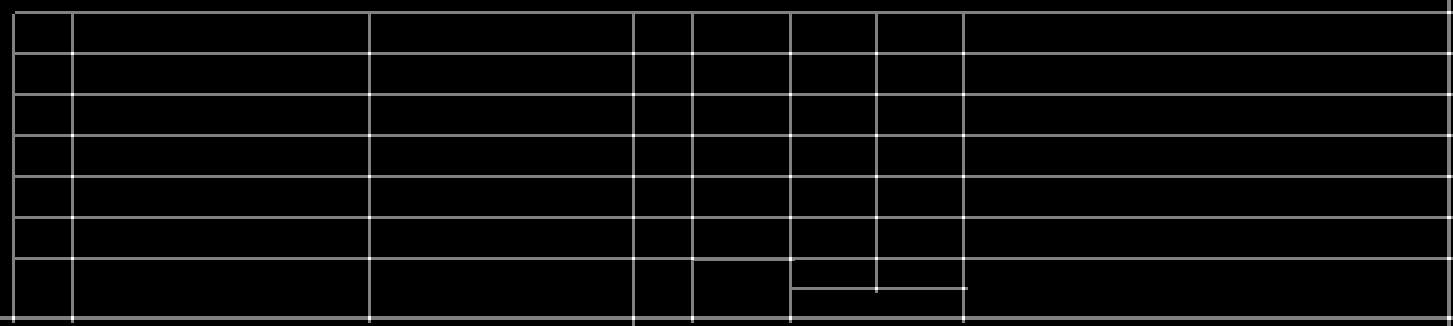

In [82]:
boxes_list = all_boxes(311)

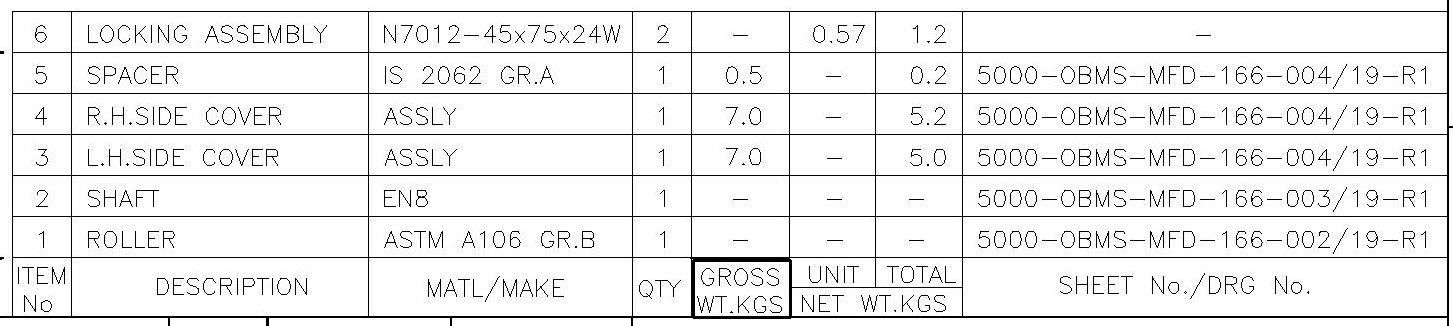

In [85]:
xx_gray_list = crop_bom(311)

for i in range(len(xx_gray_list)):
    
    xmax = 15+87+72+64+96+93+184+602+51+14
    ymax = 15+56+38+38+39+39+8
    
    cv2.rectangle(xx_gray_list[i], (693, 260 ), (693+97, 260+57), (0, 0, 0), 2)

    xx_pil = Image.fromarray(xx_gray_list[i])

    display(xx_pil)

In [84]:
boxes_list

[array([[   0.,    0., 1453.,  326.],
        [ 791.,  289.,  172.,   28.],
        [ 693.,  260.,   97.,   57.],
        [ 964.,  259.,  484.,   58.],
        [ 877.,  259.,   86.,   29.],
        [ 791.,  259.,   85.,   29.],
        [ 634.,  259.,   58.,   58.],
        [ 370.,  259.,  263.,   58.],
        [  73.,  259.,  296.,   58.],
        [  14.,  259.,   58.,   58.],
        [ 964.,  218.,  484.,   40.],
        [ 877.,  218.,   86.,   40.],
        [ 791.,  218.,   85.,   40.],
        [ 693.,  218.,   97.,   40.],
        [ 634.,  218.,   58.,   40.],
        [ 370.,  218.,  263.,   40.],
        [  73.,  218.,  296.,   40.],
        [  14.,  218.,   58.,   40.],
        [ 964.,  177.,  484.,   40.],
        [ 877.,  177.,   86.,   40.],
        [ 791.,  177.,   85.,   40.],
        [ 693.,  177.,   97.,   40.],
        [ 634.,  177.,   58.,   40.],
        [ 370.,  177.,  263.,   40.],
        [  73.,  177.,  296.,   40.],
        [  14.,  177.,   58.,   40.],
        [ 96

In [9]:
## Take out header boxe and all other box info for all items separately :

def header_and_item(img_id):
    
    boxes_list = all_boxes(img_id)
    
    col_count_list = []
    header_boxes_list = []
    bom_boxes_list = []
    item_index_width_list = []
    
    for i in range(len(boxes_list)):
    
        boxes_1 = boxes_list[i][1:]   ## removing the line of full box i.e. removing 0th row
        

        ## Find number of columns i.e. max occurance of any y value :

        y_list = boxes_1[:, 1].tolist()   ## since boxes are in x,y,w,h format (output from cv2.boundingRect)

        col_count_array = np.bincount(y_list)  ## no. of occurances of each y-value
        col_count = col_count_array.max()  ## max. no. of occurances of y-value

        print('No. of columns = ', col_count)
        

        # Now fid the Header row. In drawings, header row is always at the bottom and cv2.boundingRect always starts,
        # after the 1st row which is box of complete BOM, from bottom right

        # So, y value of boxes[1] is the bottom_most-right_most (in this order) cell y value.

        y_bmrm_cell = boxes_1[0][1]

        num_col = y_list.count(y_bmrm_cell)   ## no. of occurances of y_bmrm_cell value

        if num_col == col_count:
    
            y_header_row = y_bmrm_cell
            item_index_width = boxes_1[col_count-1, 2]
            bom_boxes_1 = boxes_1[1:]   ## remove 1st header row for bom consideration
    
        else:
        
            y_next_cell = boxes_1[1][1]

            num_col = y_list.count(y_next_cell)

            if num_col == col_count:
    
                y_header_row = y_next_cell
                item_index_width = boxes_1[col_count, 2]
                bom_boxes_1 = boxes_1[2:]    ## remove 1st 2 rows for bom consideration

        header_boxes = boxes_1[boxes_1[:, 1] == y_header_row]
    
        bom_boxes = bom_boxes_1[bom_boxes_1[:, 1] != y_header_row]
        
        col_count_list.append(col_count)
        item_index_width_list.append(item_index_width)
        header_boxes_list.append(header_boxes)
        bom_boxes_list.append(bom_boxes)
    
    return col_count_list, item_index_width_list , header_boxes_list, bom_boxes_list  ## all boxes in x, y, w, h format


In [10]:
## Making the dataframe of BOM :

def bom_df(img_id):
    
    col_count_list, item_index_width_list, header_boxes_list, bom_boxes_list =  header_and_item(img_id)
    
    xx_gray_list = crop_bom(img_id)
    
    ## First find the header info - only one header box will be considered out of list :
    ## It is expected that all header info in one drawing should be same :
    
    
#    print(type(col_count_list), '====', col_count_list)
#    print(type(item_index_width_list), '====', item_index_width_list)
    
#    print('item index width = ', item_index_width_list)

    width_list = header_boxes_list[0][:,2]   # to find width of columns
    x_list = header_boxes_list[0][:, 0]
    
    width_frequency = np.unique(width_list, return_counts=True)[1] # to check how many columns of same width
    
    
    
    print('width_frequency = ', width_frequency)
    
    print('width list = ', width_list)

    
    # Make a list of widths of all columns 
    
    all_width_list = bom_boxes_list[0][:,2].tolist() ## serialised from right to left
    row_count_array = np.bincount(all_width_list)  ## no. of occurances of each width-value
    row_count_apparent = row_count_array.max()
    
    row_count = row_count_apparent // np.max(width_frequency)
    
    print('Row count = ', row_count)
    
    
    aa = header_boxes_list[0].tolist()
    
    
    header_text = []

    for i in range(len(aa)):
    
        yy_gray = xx_gray_list[0][int(aa[i][1]-1):int(aa[i][1] + aa[i][3] - 1), int(aa[i][0]-1):int(aa[i][0] + aa[i][2] - 1)]
    
        thresh, yy_gray_1 = cv2.threshold(yy_gray, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        text = pytesseract.image_to_string(yy_gray_1, config='--psm 6 --oem 2')

        header_text.append(text)
    
    serialised_header_text = header_text[::-1]
    
#    print(serialised_header_text)
    
    ## Now find all item or BOM info :
    
    num_item = 0
    bom_text = []
    item_count = 0
    
    for i in range(len(bom_boxes_list)):
        
#        print('bom_boxes_list = ', len(bom_boxes_list))
        
#        print(bom_boxes_list[i])
        
        item_count = item_count + np.count_nonzero(bom_boxes_list[i][:, 2] == item_index_width_list[i])
        
        if width_frequency[0] > 1:        # this shows more cols of same width as index col.
            
            item_count = item_count // width_frequency[0]
            
        print('No. of Items = ', item_count)
            
        y_unique = np.unique(bom_boxes_list[i][:,1])  # serialised from top to bottom
        y_unique = y_unique[::-1]        ## serialised from bottom to top
        
#        print(y_unique)

#        num_item = num_item + len(y_unique)

        for j in y_unique:
    
            bom_sub_text = []
            aa = np.ones((col_count_list[0], 4))
        
            # bb = bom_boxes_list[i]
    
            bb = bom_boxes_list[i][bom_boxes_list[i][:, 1] == j]
        
#            print(bb)
#            print('==================================================')
            
            for k in range(len(width_list)):
                for l in range(len(bb)):
                    if (bb[l][2]+bb[l][0]) == (width_list[k]+x_list[k]):
                        aa[k, :] = bb[l, :]
                        
#            print(aa)
#            print('=======================================================')
#            print('=======================================================')

            
            for k in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
                yy_gray = xx_gray_list[i][int(aa[k][1]-1):int(aa[k][1] + aa[k][3] - 1), int(aa[k][0]-1):int(aa[k][0] + aa[k][2] - 1)]
                
                yyy_gray = unsharp_mask(yy_gray)
                
                text = pytesseract.image_to_string(yyy_gray, config='--psm 6 --oem 3')
            
#                print('k value = ', k, 'text value = ', text)
        
                bom_sub_text.append(text)
    
            bom_sub_text_rev = bom_sub_text[::-1]
#            print('length of sub_text = ', len(bom_sub_text_rev))
            bom_text.append(bom_sub_text_rev)
            
        
            
        #Creating a dataframe of the generated OCR list
    arr = np.array(bom_text)
             
    dataframe = pd.DataFrame(arr.reshape(row_count, col_count_list[0]), columns = serialised_header_text)
    
    return dataframe


In [71]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1, amount=1, threshold=0):
    

    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    """
    sharpened = float(amount + 1) * image - float(amount) * blurred
    
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    
    sharpened = sharpened.round().astype(np.uint8)
    
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    
    """
    return blurred

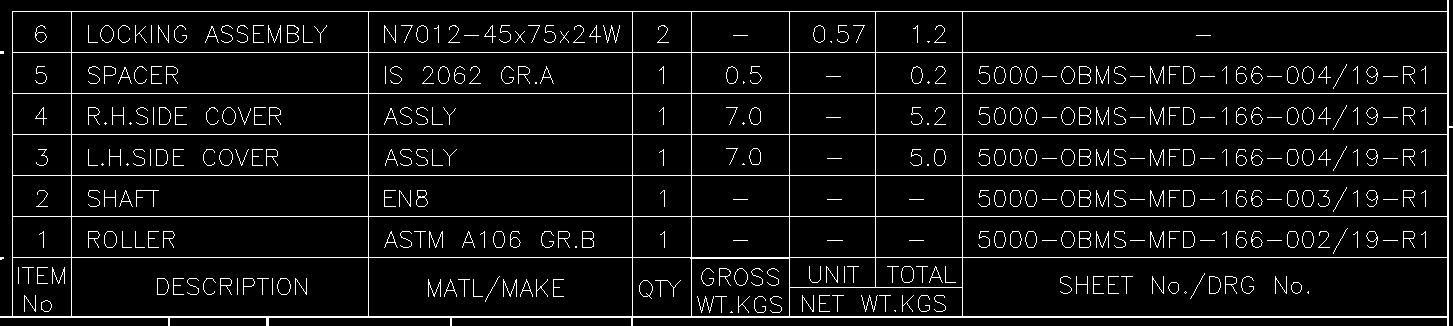

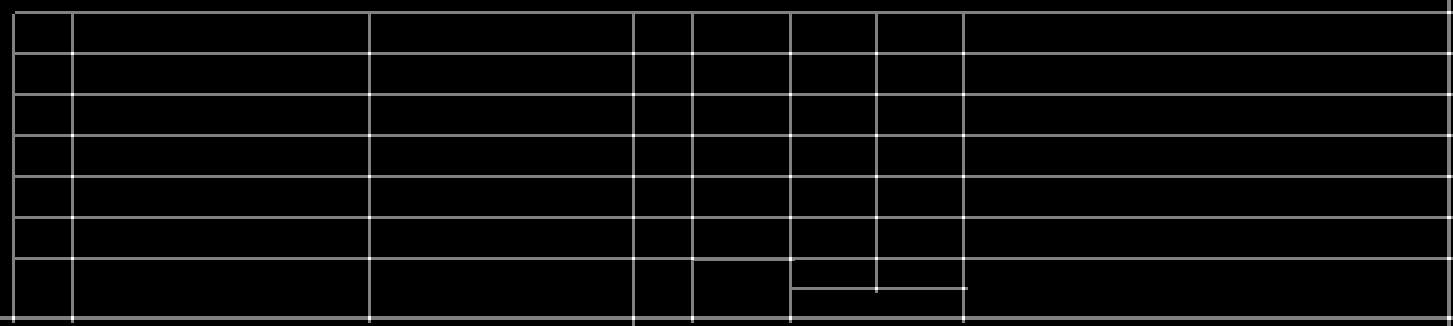

No. of columns =  8
[[791. 289. 172.  28.]
 [693. 260.  97.  57.]
 [964. 259. 484.  58.]
 [877. 259.  86.  29.]
 [791. 259.  85.  29.]
 [634. 259.  58.  58.]
 [370. 259. 263.  58.]
 [ 73. 259. 296.  58.]
 [ 14. 259.  58.  58.]
 [964. 218. 484.  40.]
 [877. 218.  86.  40.]
 [791. 218.  85.  40.]
 [693. 218.  97.  40.]
 [634. 218.  58.  40.]
 [370. 218. 263.  40.]
 [ 73. 218. 296.  40.]
 [ 14. 218.  58.  40.]
 [964. 177. 484.  40.]
 [877. 177.  86.  40.]
 [791. 177.  85.  40.]
 [693. 177.  97.  40.]
 [634. 177.  58.  40.]
 [370. 177. 263.  40.]
 [ 73. 177. 296.  40.]
 [ 14. 177.  58.  40.]
 [964. 136. 484.  40.]
 [877. 136.  86.  40.]
 [791. 136.  85.  40.]
 [693. 136.  97.  40.]
 [634. 136.  58.  40.]
 [370. 136. 263.  40.]
 [ 73. 136. 296.  40.]
 [ 14. 136.  58.  40.]
 [964.  95. 484.  40.]
 [877.  95.  86.  40.]
 [791.  95.  85.  40.]
 [693.  95.  97.  40.]
 [634.  95.  58.  40.]
 [370.  95. 263.  40.]
 [ 73.  95. 296.  40.]
 [ 14.  95.  58.  40.]
 [964.  54. 484.  40.]
 [877.  54.  8

UnboundLocalError: local variable 'y_header_row' referenced before assignment

In [80]:
df = bom_df(311)

df.head(20)

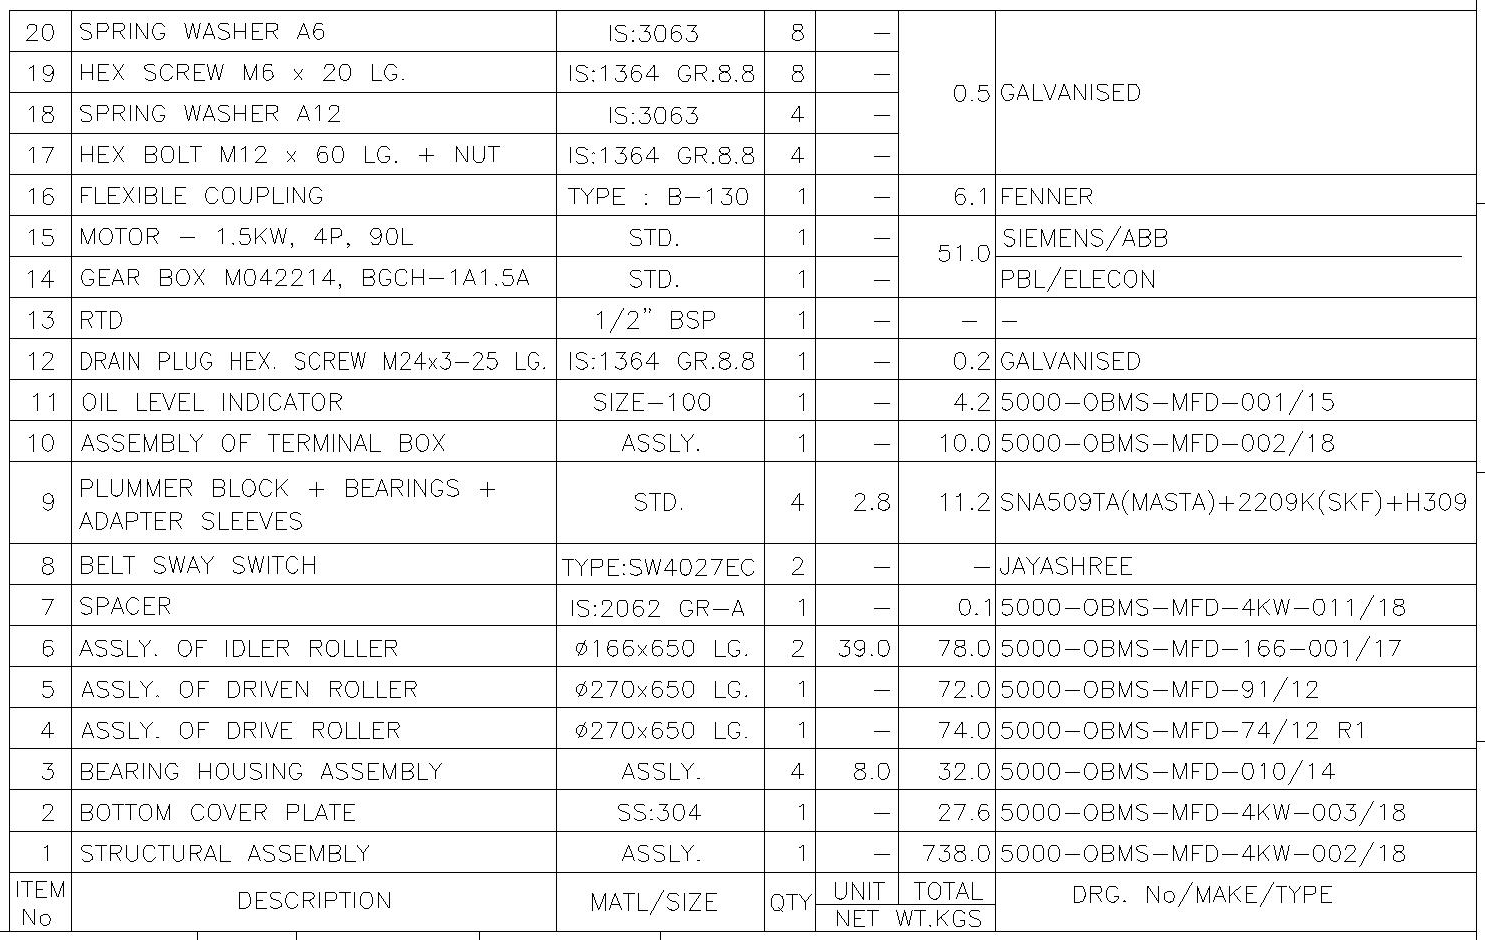

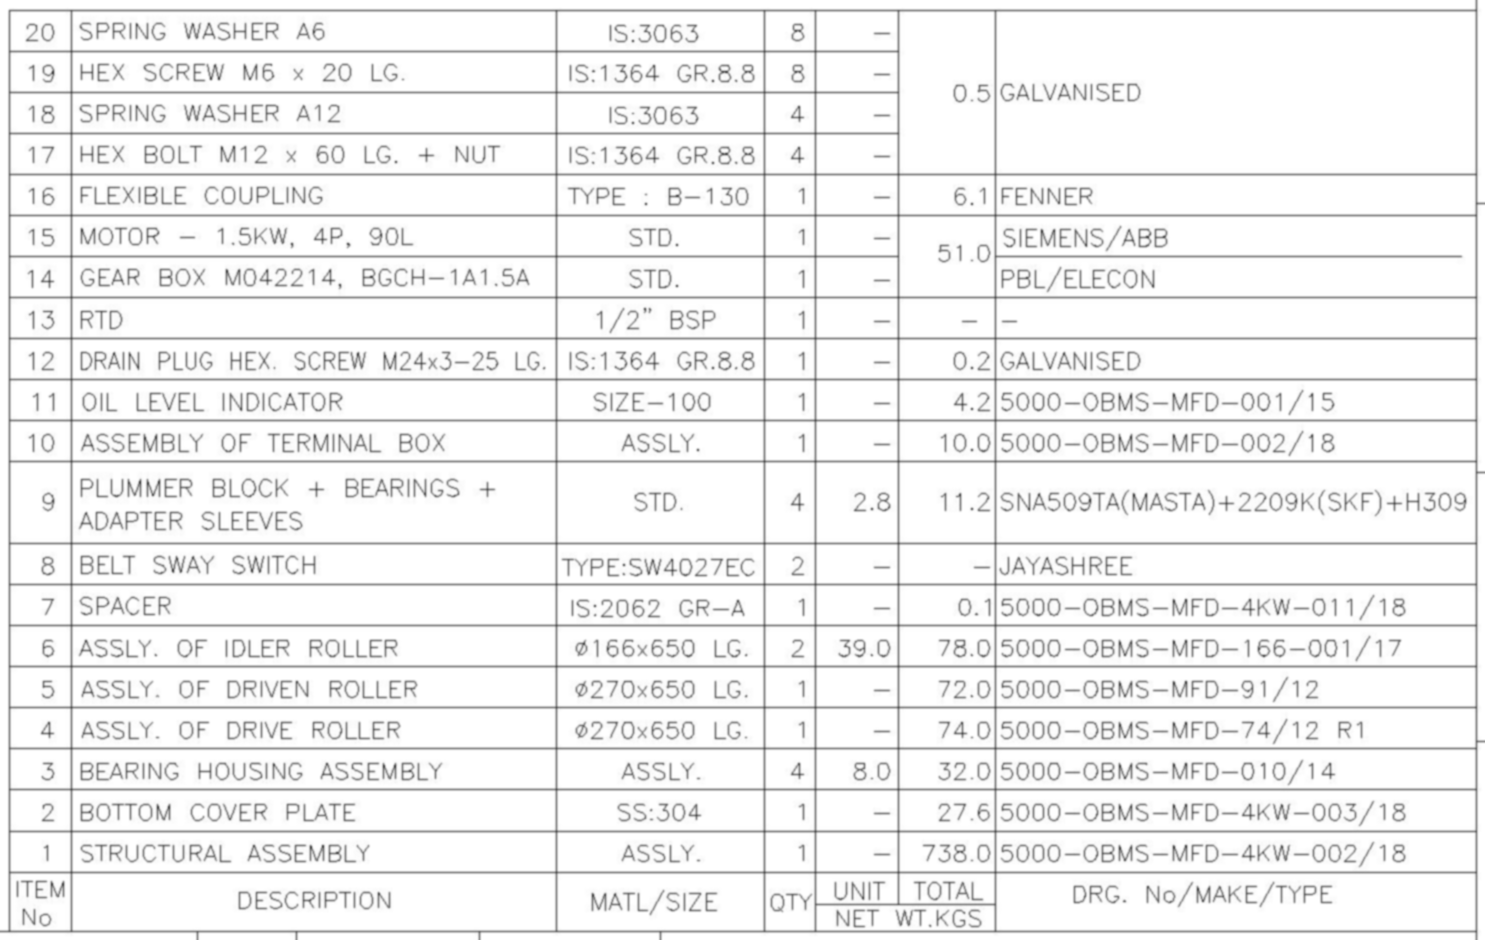

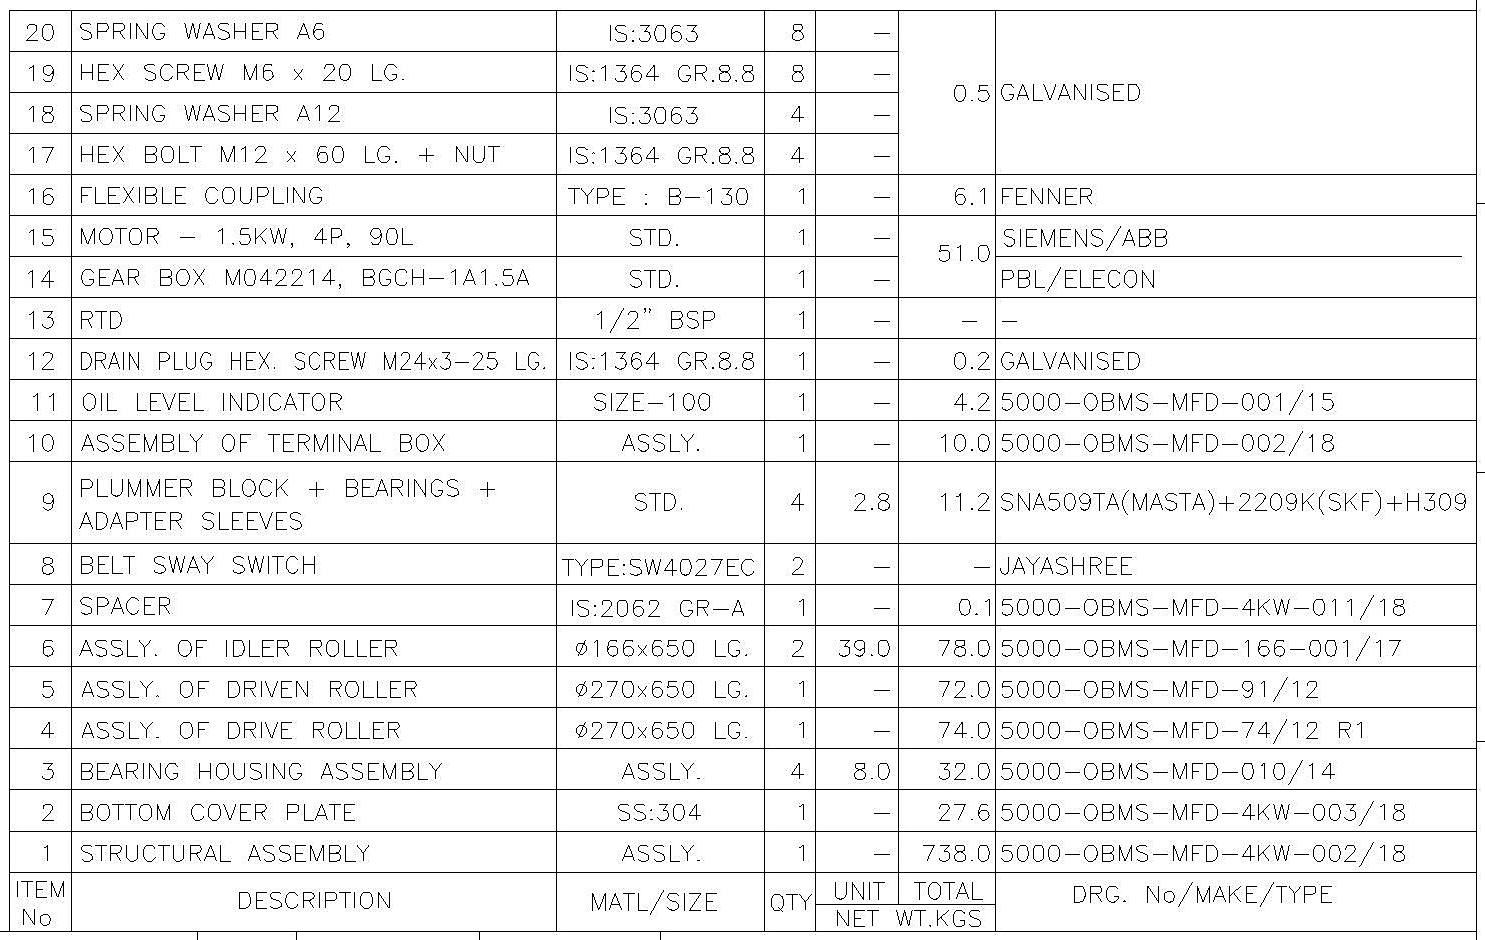

In [91]:
amount = 1
xx_gray_list = crop_bom(608)

for i in range(len(xx_gray_list)):

    xx_pil = Image.fromarray(xx_gray_list[i])
    display(xx_pil)
    
    blurred = cv2.GaussianBlur(xx_gray_list[i], (5, 5), 1)
    
    
    xx_pil = Image.fromarray(blurred)
    display(xx_pil)
    print('=========================================================================')
    
    yyy = unsharp_mask(xx_gray_list[i])
    yyy_pil = Image.fromarray(yyy)
    display(yyy_pil)
    

In [11]:
## Making the dataframe of BOM :

def bom_df_rev(img_id):
    
    col_count_list, item_index_width_list, header_boxes_list, bom_boxes_list =  header_and_item(img_id)
    
    xx_gray_list = crop_bom(img_id)
    
    ## First find the header info - only one header box will be considered out of list :
    ## It is expected that all header info in one drawing should be same :
    
    
#    print(type(col_count_list), '====', col_count_list)
#    print(type(item_index_width_list), '====', item_index_width_list)
    
#    print('item index width = ', item_index_width_list)

    width_list = header_boxes_list[0][:,2]   # to find width of columns
    x_list = header_boxes_list[0][:, 0]
    
    width_frequency = np.unique(width_list, return_counts=True)[1] # to check how many columns of same width
    
    
    
    print('width_frequency = ', width_frequency)
    
    print('width list = ', width_list)

    
    # Make a list of widths of all columns 
    
    all_width_list = bom_boxes_list[0][:,2].tolist() ## serialised from right to left
    row_count_array = np.bincount(all_width_list)  ## no. of occurances of each width-value
    row_count_apparent = row_count_array.max()
    
    row_count = row_count_apparent // np.max(width_frequency)
    
    print('Row count = ', row_count)
    
    
    aa = header_boxes_list[0].tolist()
    
    
    header_text = []
    kount = 0

    for i in range(len(aa)):
    
        yy_gray = xx_gray_list[0][int(aa[i][1]-1):int(aa[i][1] + aa[i][3] - 1), int(aa[i][0]-1):int(aa[i][0] + aa[i][2] - 1)]
    
        thresh, yy_gray_1 = cv2.threshold(yy_gray, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        text = pytesseract.image_to_string(yy_gray_1, config='--psm 6 --oem 2')

        
        header_text.append(text)
        
    header_text.append('img_id')
    serialised_header_text = header_text[::-1]
    
#    print(serialised_header_text)
    
    ## Now find all item or BOM info :=======================================================================
    
    num_item = 0
    bom_text = []
    item_count = 0
    
    for i in range(len(bom_boxes_list)):
        
#        print('bom_boxes_list = ', len(bom_boxes_list))
        
#        print(bom_boxes_list[i])
        
        item_count = item_count + np.count_nonzero(bom_boxes_list[i][:, 2] == item_index_width_list[i])
        
        if width_frequency[0] > 1:        # this shows more cols of same width as index col.
            
            item_count = item_count // width_frequency[0]
            
        print('No. of Items = ', item_count)
            
        y_unique = np.unique(bom_boxes_list[i][:,1])  # serialised from top to bottom
        y_unique = y_unique[::-1]        ## serialised from bottom to top
        
#        print(y_unique)

#        num_item = num_item + len(y_unique)

        for j in y_unique:
    
            bom_sub_text = []
            aa = np.ones((col_count_list[0], 4))
        
            # bb = bom_boxes_list[i]
    
            bb = bom_boxes_list[i][bom_boxes_list[i][:, 1] == j]
        
#            print(bb)
#            print('==================================================')
            
            for k in range(len(width_list)):
                for l in range(len(bb)):
                    if (bb[l][2]+bb[l][0]) == (width_list[k]+x_list[k]):
                        aa[k, :] = bb[l, :]
                        
#            print(aa)
#            print('=======================================================')
#            print('=======================================================')

            
            for k in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
                yy_gray = xx_gray_list[i][int(aa[k][1]-1):int(aa[k][1] + aa[k][3] - 1), int(aa[k][0]-1):int(aa[k][0] + aa[k][2] - 1)]
        
                text = pytesseract.image_to_string(yy_gray, config=' --psm 6 --oem 3')
            
#                print('text type = ', type(text), 'text value = ', text)
        
                bom_sub_text.append(text)
            
                kount = kount + 1
                
                if kount == col_count_list[0]:
                    bom_sub_text.append(img_id)
                    kount = 0
                
                
    
            bom_sub_text_rev = bom_sub_text[::-1]
        
            
#            print('length of sub_text = ', len(bom_sub_text_rev))
            bom_text.append(bom_sub_text_rev)
            
        
            
        #Creating a dataframe of the generated OCR list
    arr = np.array(bom_text)
    
    arr_reshape = arr.reshape(row_count, col_count_list[0]+1)
             
#    dataframe = pd.DataFrame(arr.reshape(row_count, col_count_list[0]), columns = serialised_header_text)
    
    return arr_reshape, serialised_header_text


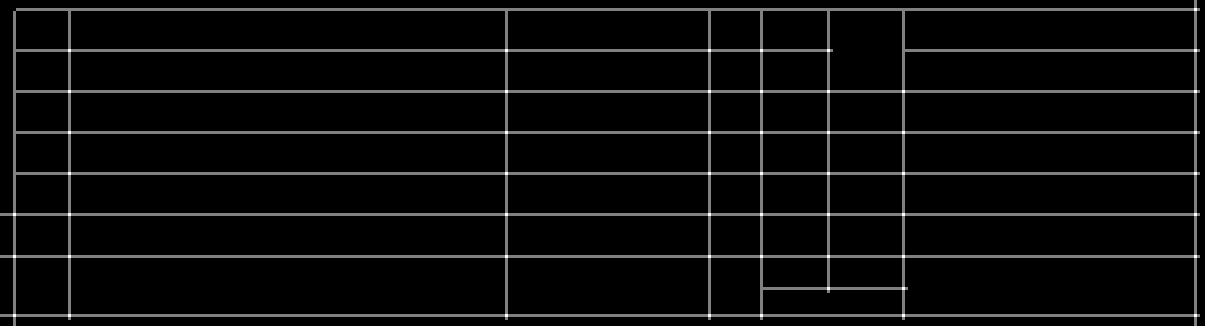

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [291.  74.  66.  51. 202. 436.  54.]
Row count =  6
No. of Items =  6


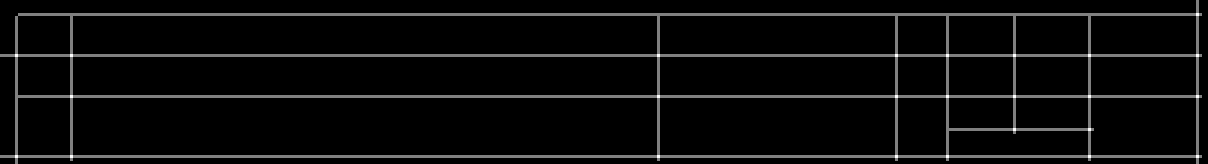

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [107.  74.  66.  50. 237. 586.  54.]
Row count =  2
No. of Items =  2


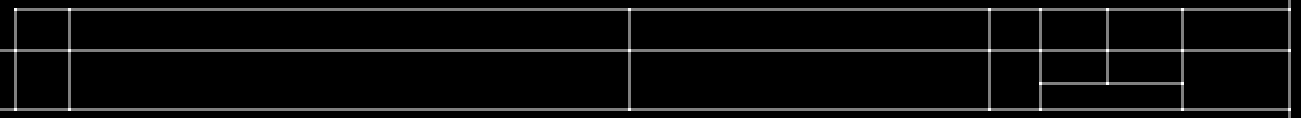

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [106.  74.  66.  50. 359. 559.  53.]
Row count =  1
No. of Items =  1


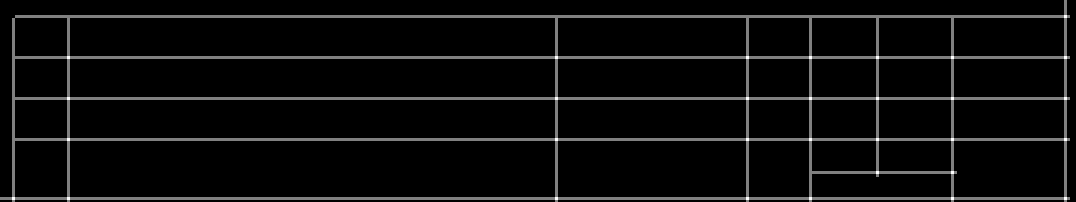

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [112.  74.  66.  62. 190. 487.  54.]
Row count =  3
No. of Items =  3


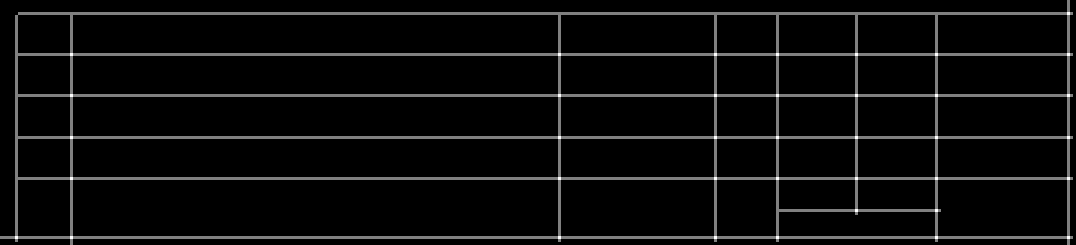

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [131.  79.  78.  61. 155. 487.  54.]
Row count =  4
No. of Items =  4


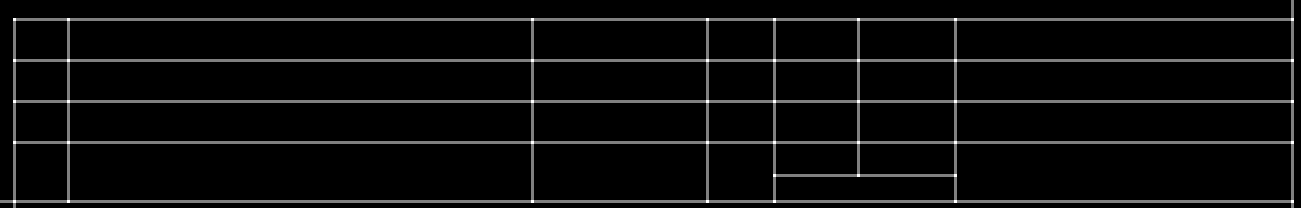

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [336.  96.  83.  66. 174. 463.  53.]
Row count =  3
No. of Items =  3


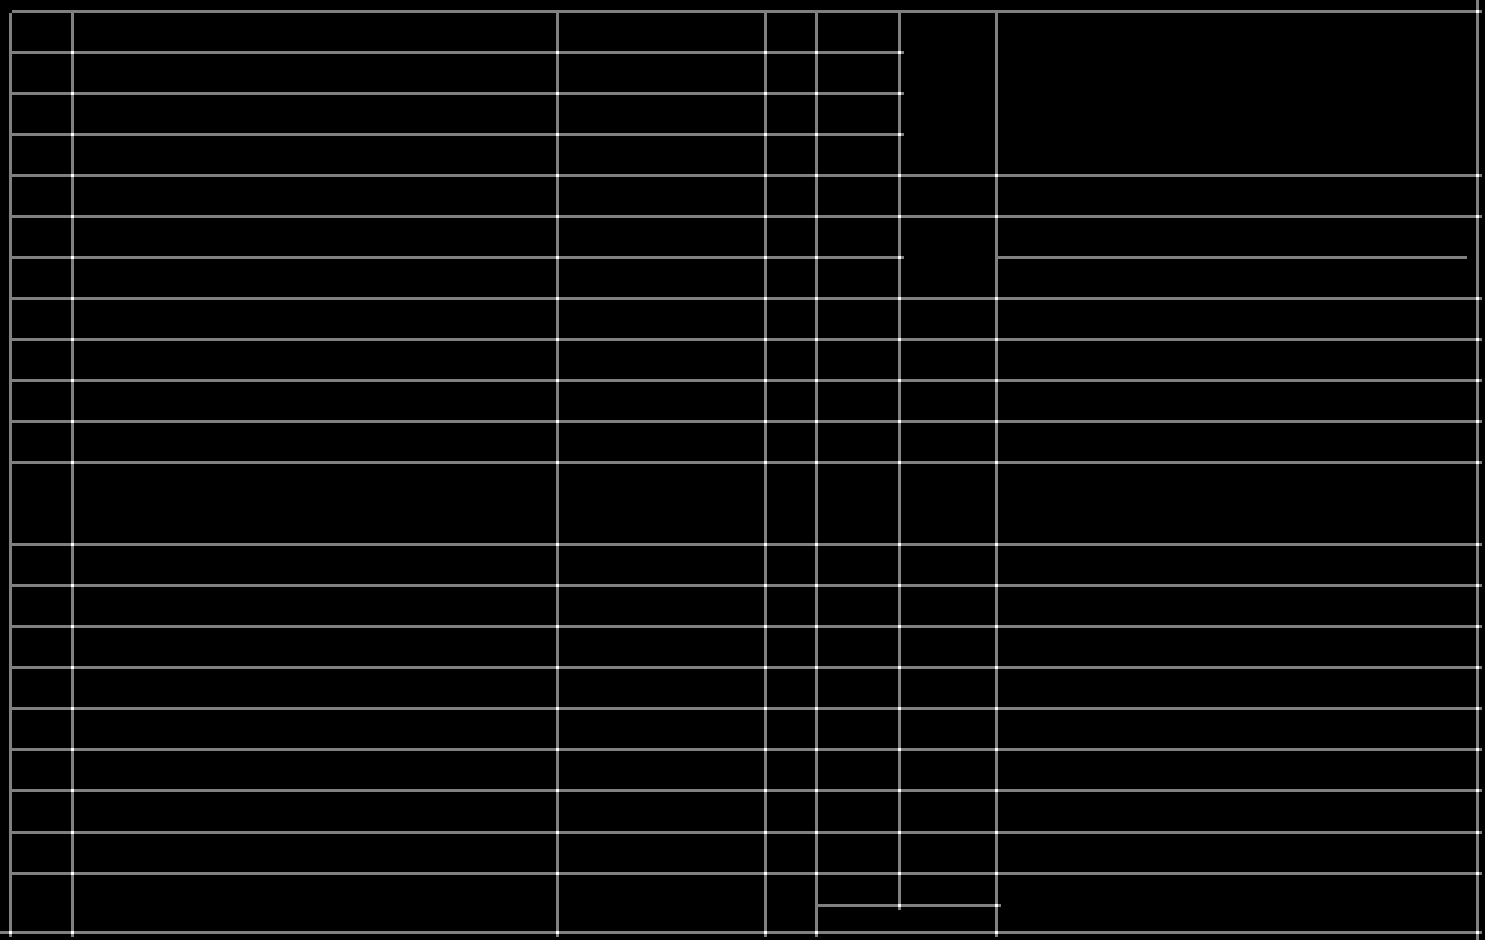

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [480.  96.  82.  50. 207. 484.  61.]
Row count =  20
No. of Items =  20


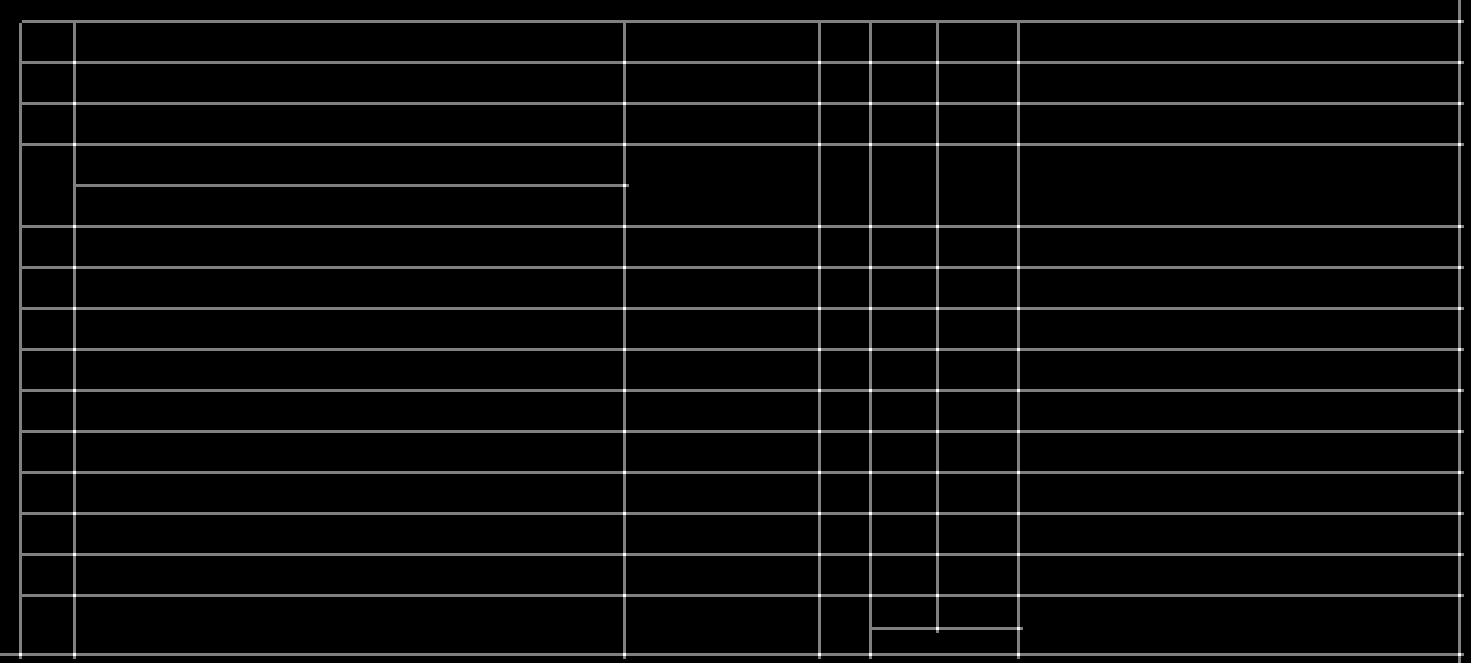

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [440.  80.  66.  50. 194. 549.  53.]
Row count =  14
No. of Items =  13


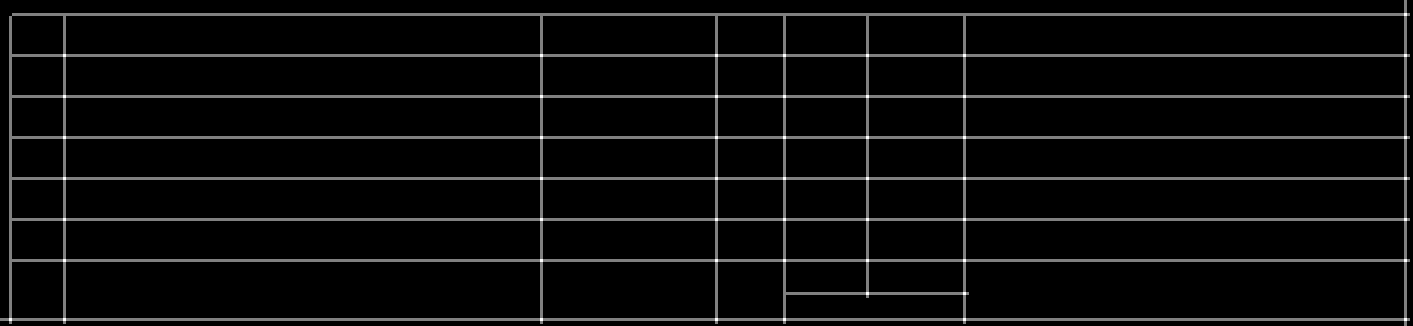

No. of columns =  7
width_frequency =  [1 1 1 1 1 1 1]
width list =  [440.  96.  82.  67. 174. 476.  53.]
Row count =  6
No. of Items =  6


In [23]:
my_list = [602,603,604,605,606,607,608,609, 610]

all_bom_list = []
for i in my_list:
    
    individual_bom, serialised_header_text = bom_df_rev(i)
    
    all_bom_list.append(individual_bom)
    
all_bom_array = np.vstack((all_bom_list))
all_bom_df = pd.DataFrame(all_bom_array, columns = serialised_header_text)

# making all descriptions in lower case :
all_bom_df['DESCRIPTION'] = all_bom_df['DESCRIPTION'].map(lambda x: x if type(x)!=str else x.lower())

for i in range(len(all_bom_df)):

    all_bom_df.iloc[i, 2] = all_bom_df.iloc[i, 2].replace('1/d', 'i/d')
    all_bom_df.iloc[i, 2] = all_bom_df.iloc[i, 2].replace('0/d', 'o/d')

In [24]:
all_bom_df[0:20]

img_id ITEM\nNo                             DESCRIPTION  \
0     602        1                   magnet holder details   
1     602        2                            locking ring   
2     602        3                         magnet assembly   
3     602       4.            intermediate magnet assembly   
4     602        $                      hex screw mgx20 lg   
5     602        6                        spring washer a6   
6     603        a  pipe 114.3 o/d x 11.1thk— c+5 l6 (m/c)   
7     603        b         pl 5 thk 45 i/d x 100 o/d (m/c)   
8     604        a         pl 16 thk 30 i/d x 80 o/d (m/c)   
9     605        a          sht 1.6mm thk 116 x ml  (bent)   
10    605        b                   sht 1.6mm thk 36 x 38   
11    605        C                                 magnets   
12    606        0             pl 2thk 22 x ml1 (cut&bent)   
13    606        b            sht 1.6mm thk 43 x ml (bent)   
14    606        &                   sht 1.6mm thk 12 x 14   
15    606        d                                 magnets   
16    607        1             plate 2thk x 150 x 600 bend   
17    607        2              plate 2thk x 180 x 205 cut   
18    607        3                    bar #6 — 177 lg bend   
19    608        1                     structural assembly   

                   MATL/MAKE   QTY   UNIT  TOTAL          DRG. No/SHEET No  
0                      ASSLY     1                                    SH—2  
1               15:2062 GR—A     3    0.3    0.6                      SH—3  
2                      ASSLY     $                                    SH—4  
3                      ASSLY    4.                                    Sh—5  
4             15:1364 CR 8.8    4.                                      ho  
5                    15:3063    4.           0.1                         o  
6             ASTM A106 CR—B     1                                          
7                     SS 304     2    0.2    0.4                            
8   MILD/CAst stEEL (iS4491)     2    9.2     OA                            
9                     SS 304     1                                          
10                    SS 304     2   0.01   0.02                            
11                   FERRITE  1SET                                          
12                    SS 304     1                                          
13                    SS 304     1                                          
14                    SS 304     2  0.002  0.004                            
15                   FERRITE  1SET                                          
16              15:2062 GR.A     1           1.4                            
17              1§:2062 GR.A     2   9.25    0.5                            
18                      M.S.     1           0.1                            
19                    ASSLY.     1         738.0  5000—OBMS—MFD—4kW—002/18

In [95]:
# Separating out assembly items and basic items :

df1 = all_bom_df.iloc[:,-1]  # separating out last 'drg' column

mask = []

for i in range(len(all_bom_df)):
    
    mask.append(len(list(all_bom_df.iloc[:,-1][i])) >= 3)    # create boolean mask to check no. of characters >= 3  
                                                             # to indicate presence of drawing no.

mask = pd.Series(mask)

all_bom_assy_item = all_bom_df[mask].reset_index(drop=True)   # Dataframe for assembly items
all_bom_raw_item = all_bom_df[~mask].reset_index(drop=True)   # Dataframe for basic/raw items

In [26]:
# finding plates and sheets :

all_bom_df.iloc[:, 2] = all_bom_df.iloc[:, 2].map(lambda x: x if type(x)!=str else x.lower())  # making lower case

words = ['plate', 'pl', 'sheet', 'sht']
digits = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

mask = []

# First match with words list :

for i in range(len(all_bom_df)):
    
    mask.append(bool(set(words).intersection(all_bom_df.iloc[i, 2].split())))    # create boolean mask for plate/sht  
                                                             

mask = pd.Series(mask)

all_bom_plate_item = all_bom_df[mask].reset_index(drop=True)   # Dataframe for assembly items
all_bom_other_item = all_bom_df[~mask].reset_index(drop=True)   # Dataframe for basic/raw items

# Then match with digits list since for pure plate items there has to be dimensions :

mask = []

for i in range(len(all_bom_plate_item)):
    
    mask.append(bool(set(digits).intersection(list(all_bom_plate_item.iloc[i, 2]))))    # create boolean mask for plate/sht  
                                                             

mask = pd.Series(mask)

all_bom_plate = all_bom_plate_item[mask].reset_index(drop=True)   # Dataframe for assembly items



In [27]:
#finding pipes and rounds :

all_bom_df.iloc[:, 2] = all_bom_df.iloc[:, 2].map(lambda x: x if type(x)!=str else x.lower())  # making lower case

mask = []

words = ['pipe', 'round', 'bar', 'shaft']
digits = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

for i in range(len(all_bom_other_item)):
    
    mask.append(bool(set(words).intersection(all_bom_other_item.iloc[i, 2].split())))    # create boolean mask for plate/sht  
                                                             

mask = pd.Series(mask)

all_bom_round_item = all_bom_other_item[mask].reset_index(drop=True)   # Dataframe for assembly items
all_bom_other_item = all_bom_other_item[~mask].reset_index(drop=True)   # Dataframe for basic/raw items

In [28]:
all_bom_plate.head(20)

img_id ITEM\nNo                      DESCRIPTION                 MATL/MAKE  \
0     603        b  pl 5 thk 45 i/d x 100 o/d (m/c)                    SS 304   
1     604        a  pl 16 thk 30 i/d x 80 o/d (m/c)  MILD/CAst stEEL (iS4491)   
2     605        a   sht 1.6mm thk 116 x ml  (bent)                    SS 304   
3     605        b            sht 1.6mm thk 36 x 38                    SS 304   
4     606        0      pl 2thk 22 x ml1 (cut&bent)                    SS 304   
5     606        b     sht 1.6mm thk 43 x ml (bent)                    SS 304   
6     606        &            sht 1.6mm thk 12 x 14                    SS 304   
7     607        1      plate 2thk x 150 x 600 bend              15:2062 GR.A   
8     607        2       plate 2thk x 180 x 205 cut              1§:2062 GR.A   
9     609       13          plate 10thk x 160 x 205              15:2062 GR—A   
10    610        1     plate 32thk x 600 x 600 m/cd              15:2062 CR.B   
11    610        2          plate 25thk x 718 x 868              15:2062 CR.B   
12    610        3      plate 16thk x 405 x 868 cut               1$:2062 CRA   
13    610        4          plate 16thk x 405 x 868              1$:2062 GR.A   
14    610        5          plate 16thk x 405 x 734              1$:2062 GR.A   

   QTY   UNIT  TOTAL           DRG. No/SHEET No  
0    2    0.2    0.4                             
1    2    9.2     OA                             
2    1                                           
3    2   0.01   0.02                             
4    1                                           
5    1                                           
6    2  0.002  0.004                             
7    1           1.4                             
8    2   9.25    0.5                             
9    2    2.6     $2                          |  
10   1          86.5  5000—OBMS—MFD—4KkW—005/18  
11   1         122.0  5000—OBMS—MFD—4KkW—005/18  
12   1          41.4  5000—OBMS—MFD—4KkW—005/18  
13   1          44.2                             
14   2   $7.5   74.6

In [71]:
import re

thickness = []
length = []
width = []

all_bom_plate_final = all_bom_plate.copy()

for i in range(len(all_bom_plate)):
    
    str_1 = all_bom_plate.iloc[i,2].rpartition('thk')
    str_2= str_1[0]
    str_3 = str_1[-1]
    
    thick= re.findall(r'\d+\.?\d*', str_2)
    sz = re.findall(r'\d+', str_3)
    if len(sz) < 2:
        sz.append('1')
        
    thickness.append(float(thick[0]))
    width.append(float(sz[0]))
    length.append(float(sz[1]))
    
thk_values = pd.Series(thickness)
length_values = pd.Series(length)
width_values = pd.Series(width)
                         
all_bom_plate_final.drop(all_bom_plate_final.columns[[7]], axis=1, inplace=True) # reduce unnecessary columns


all_bom_plate_final.insert(loc=5, column='thickness', value=thk_values)
all_bom_plate_final.insert(loc=6, column='length', value=length_values)
all_bom_plate_final.insert(loc=7, column='width', value=width_values)



In [72]:
all_bom_plate_final.head(20)

img_id ITEM\nNo                      DESCRIPTION                 MATL/MAKE  \
0     603        b  pl 5 thk 45 i/d x 100 o/d (m/c)                    SS 304   
1     604        a  pl 16 thk 30 i/d x 80 o/d (m/c)  MILD/CAst stEEL (iS4491)   
2     605        a   sht 1.6mm thk 116 x ml  (bent)                    SS 304   
3     605        b            sht 1.6mm thk 36 x 38                    SS 304   
4     606        0      pl 2thk 22 x ml1 (cut&bent)                    SS 304   
5     606        b     sht 1.6mm thk 43 x ml (bent)                    SS 304   
6     606        &            sht 1.6mm thk 12 x 14                    SS 304   
7     607        1      plate 2thk x 150 x 600 bend              15:2062 GR.A   
8     607        2       plate 2thk x 180 x 205 cut              1§:2062 GR.A   
9     609       13          plate 10thk x 160 x 205              15:2062 GR—A   
10    610        1     plate 32thk x 600 x 600 m/cd              15:2062 CR.B   
11    610        2          plate 25thk x 718 x 868              15:2062 CR.B   
12    610        3      plate 16thk x 405 x 868 cut               1$:2062 CRA   
13    610        4          plate 16thk x 405 x 868              1$:2062 GR.A   
14    610        5          plate 16thk x 405 x 734              1$:2062 GR.A   

   QTY  thickness  length  width   UNIT  TOTAL  
0    2        5.0   100.0   45.0    0.2    0.4  
1    2       16.0    80.0   30.0    9.2     OA  
2    1        1.6     1.0  116.0                
3    2        1.6    38.0   36.0   0.01   0.02  
4    1        2.0     1.0   22.0                
5    1        1.6     1.0   43.0                
6    2        1.6    14.0   12.0  0.002  0.004  
7    1        2.0   600.0  150.0           1.4  
8    2        2.0   205.0  180.0   9.25    0.5  
9    2       10.0   205.0  160.0    2.6     $2  
10   1       32.0   600.0  600.0          86.5  
11   1       25.0   868.0  718.0         122.0  
12   1       16.0   868.0  405.0          41.4  
13   1       16.0   868.0  405.0          44.2  
14   2       16.0   734.0  405.0   $7.5   74.6

In [80]:
gb = all_bom_plate_final.groupby(['thickness','MATL/MAKE'])
keys = [key for key, _ in gb]

gb.get_group(keys[1])

img_id ITEM\nNo                  DESCRIPTION     MATL/MAKE QTY  thickness  \
7    607        1  plate 2thk x 150 x 600 bend  15:2062 GR.A   1        2.0   

   length  width UNIT TOTAL  
7   600.0  150.0        1.4

In [77]:
for i in range(len(keys)):
    gb.get_group(keys[i])

In [67]:
keys

[0, 1, 2, 3]

In [104]:
all_bom_round_item.head(10)

img_id ITEM\nNo                             DESCRIPTION        MATL/MAKE  \
0    603        a  pipe 114.3 o/d x 11.1thk— c+5 l6 (m/c)   ASTM A106 CR—B   
1    607        3                    bar #6 — 177 lg bend             M.S.   
2    610        6                 bar @240 x 350 lg. m/cd  CS 19:4491 CR.2   

  QTY UNIT  TOTAL           DRG. No/SHEET No  
0   1                                         
1   1         0.1                             
2   1       109.5  5000—OBMS—MFD—4KkW—005/18

In [3]:
# load json and create model
json_file = open('/home/scar3crow/Downloads/model_drg_num_151.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model_1 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_1.load_weights("/home/scar3crow/Downloads/model_drg_num_151.h5")
print("Loaded model from disk")

# print(loaded_model_2.summary())

Loaded model from disk


In [4]:
# load json and create model
json_file = open('/home/scar3crow/Downloads/model_drg_num_152.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model_2 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_2.load_weights("/home/scar3crow/Downloads/model_drg_num_152.h5")
print("Loaded model from disk")

# print(loaded_model_2.summary())

Loaded model from disk


In [5]:
# load json and create model
json_file = open('/home/scar3crow/Downloads/model_drg_num_153.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model_3 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_3.load_weights("/home/scar3crow/Downloads/model_drg_num_153.h5")
print("Loaded model from disk")

# print(loaded_model_2.summary())

Loaded model from disk


In [35]:
## Prediction from the model :


def pred_img_1(img_resized, anchors, my_model):

    xx = img_resized
    xx = (xx - 127.5)/ 255.

    xx = np.expand_dims(xx, axis = 0)

    pred_1 = my_model.predict(xx)
  
    grid_size = [38., 38.]
    grid_stride = 608. / grid_size[0]

    grid_x = np.arange(grid_size[1])
    grid_y = np.arange(grid_size[0])
    
    a = np.array(np.meshgrid(grid_x, grid_y))
    b = np.array(np.meshgrid(grid_x, grid_y))
    c = np.array(np.meshgrid(grid_x, grid_y))
    d = np.concatenate((a,b,c), axis = 0)
    e = d.transpose(2, 1, 0)
    grid_final = np.reshape(e,[1,int(grid_size[0]),int(grid_size[1]),3,2])
    grid_final[..., [0,1]] = grid_final[..., [1,0]]
    
    grid_final_tf = tf.convert_to_tensor(grid_final, np.float32)

    pred_1_xy = K.sigmoid(pred_1[..., :2]) + grid_final_tf
    pred_1_xy = (pred_1_xy * grid_stride) / 608.
    pred_1_wdht = K.exp(pred_1[..., 2:4]) * (anchors / 608.)
    pred_1_obj = K.sigmoid(pred_1[..., 4:5])
    pred_1_cls = K.sigmoid(pred_1[..., 5:6])

    array_1 = K.concatenate([pred_1_xy, pred_1_wdht], axis = -1)
    array_2 = K.concatenate([array_1, pred_1_obj], axis = -1)
    array_3 = K.concatenate([array_2, pred_1_cls], axis = -1)
    array_4 = K.eval(array_3)

    boxes_wrt_target = array_1
    box_score = pred_1_obj*pred_1_cls

    array_5 = K.concatenate([array_2, box_score], axis = -1)
    array_6 = K.eval(array_5)

    array_6_reshaped = np.reshape(array_6, [int(grid_size[0])*int(grid_size[1])*3, 6])

    array_class = array_6_reshaped[array_6_reshaped[:,5].argsort()[::-1]] ## sorting 2-d array in reverse order ([::-1]) on col 5 ([:,5])
#  array_6_class_2 = array_6_reshaped[array_6_reshaped[:,6].argsort()[::-1]] 
#  array_6_class_3 = array_6_reshaped[array_6_reshaped[:,7].argsort()[::-1]] 
#  array_6_class_4 = array_6_reshaped[array_6_reshaped[:,8].argsort()[::-1]] 
#  array_6_class_5 = array_6_reshaped[array_6_reshaped[:,9].argsort()[::-1]]



    return array_class, pred_1   ## shape of array_class is 1(num_class), 1083(19*19*3), 6

In [8]:
## Using prediction to get box sizes w.r.t. actual image and corresponding class names :

def actual_box_and_class_1(image_sl, anchors, target_size, my_model):
    

  ## imaqge_sl = file name of image i.e. for filename = 101a.jpg, image_sl = 101
  ## my_model = trained model

    image_id = str(image_sl) + '.jpg'

    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
  
    img = cv2.imread(image_path)

    height, width, _ = img.shape

    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    
#  img_resized = unsharp_mask(img_resized)

    array_class, _ = pred_img_1(img_resized, anchors, my_model)   ## shape of array_class is 1(num_class), 1083(19*19*3), 6

#    print('array_class_shape = ', array_class.shape)

    box_list = []
    img_box = np.zeros((1,4))

    """

  for j in range(len(array_class)):


    c_array = np.zeros((1,5))
    img_box = np.zeros((1,4))

    c_array = array_class[j][0]
#    print(np.around(c_array, 2))

    print('c_array_shape = ', c_array.shape)

    """

    image_box_x_c = array_class[0][0] * target_size[1]  ## x_center wrt target image
    image_box_y_c = array_class[0][1] * target_size[0]
    image_box_wd = array_class[0][2] * target_size[1]
    image_box_ht = array_class[0][3] * target_size[0]

#    idx = np.argmax(c_array[5:])
#    obj_class = categories[idx]

    x_ratio = width / target_size[1]
    y_ratio = height / target_size[0]

    image_box_x_c_img = image_box_x_c * x_ratio  ## x_center wrt actual image
    image_box_y_c_img = image_box_y_c * y_ratio  ## y_center wrt actual image
    image_box_wd_img = image_box_wd * x_ratio  ## width wrt actual image 
    image_box_ht_img = image_box_ht * y_ratio  ## height wrt actual image

    box_xmin = image_box_x_c_img - image_box_wd_img / 2.
    box_ymin = image_box_y_c_img - image_box_ht_img / 2.
    box_xmax = box_xmin + image_box_wd_img
    box_ymax = box_ymin + image_box_ht_img

#    print('box_xmin = ', box_xmin)

#    img_box[j, 0] = idx
    img_box[0, 0] = box_xmin
    img_box[0, 1] = box_ymin
    img_box[0, 2] = box_xmax
    img_box[0, 3] = box_ymax

    img_box = np.where(img_box<0, 0, img_box) ## if any value becomes negative, set to zero

#    print(img_box[j])

    box_list.append(img_box[0].tolist())


    return box_list, img    ## box_list is in format xmin, ymin, xmax, ymax

In [9]:
## Draw Box with sharpened image :

def draw_box_pred(img_id, anchors, target_size, my_model):
    
    image_id = str(img_id) + '.jpg'
#    print(image_id)
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id

#    print(image_path)

    box_list, _ = actual_box_and_class_1(img_id, anchors, target_size, my_model)




# find index of image in data frame :
    """
    image_list = r_new_data['img_id'].unique() # make a list of unique images
    idx = [i for i in range(len(image_list)) if image_list[i] == image_id] # find index of image
    """
# reading image and resizing as per target image :

    x = cv2.imread(image_path)
    x_ratio = target_size[1] / x.shape[1]
    y_ratio = target_size[0] / x.shape[0]

    xx = cv2.resize(x, (target_size[1], target_size[0]))
#    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#    xx = cv2.filter2D(xx, -1, kernel)
#    xx = unsharp_mask(xx)
    """
    print('======================', xx.max())
    print('======================', xx.min())
    
# slicing as per current image id

    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[idx[0]]])].reset_index(drop=True) 

    m = int(target_size[1] / grid_size[1])  # making x-scale for making grid
    n = int(target_size[0] / grid_size[0])  # making x-scale for making grid

    x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15, m*16, m*17, m*18] 
    y_range = [0, n*1, n*2, n*3, n*4, n*5, n*6, n*7, n*8, n*9, n*10, n*11, n*12, n*13, n*14, n*15, n*16, n*17, n*18 ]

    for i in x_range:
            for j in y_range:
                cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)
            
    for j in range(len(r_new_data_slice)):
    """
    for j in range(len(box_list)):
        
        xmin = int(box_list[j][0])
        ymin = int(box_list[j][1])
    
        xxmin = int(xmin * x_ratio)
        yymin = int(ymin * y_ratio)
 
        xmax = int(box_list[j][2])
        ymax = int(box_list[j][3])
    
        xxmax = int(xmax * x_ratio)
        yymax = int(ymax * y_ratio)
        
#        obj_class = categories[int(box_list[j][0])]
    
#        print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
        cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
#        cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    
        cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
#        cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
    x_pil = Image.fromarray(x)
#    display(x_pil)

    xx_pil = Image.fromarray(xx)
#    display(xx_pil)

    return(display(x_pil))   #, display(xx_pil))

In [6]:
anchors_wrt_target = [206.94184721, 133.62827822, 224.01368301, 31.88382412, 224.44697834, 69.89915288]
anchors_wrt_target = np.reshape(anchors_wrt_target, [3,2])
print(anchors_wrt_target)
anchors = np.reshape(anchors_wrt_target, [1,1,1,3,2])

[[206.94184721 133.62827822]
 [224.01368301  31.88382412]
 [224.44697834  69.89915288]]


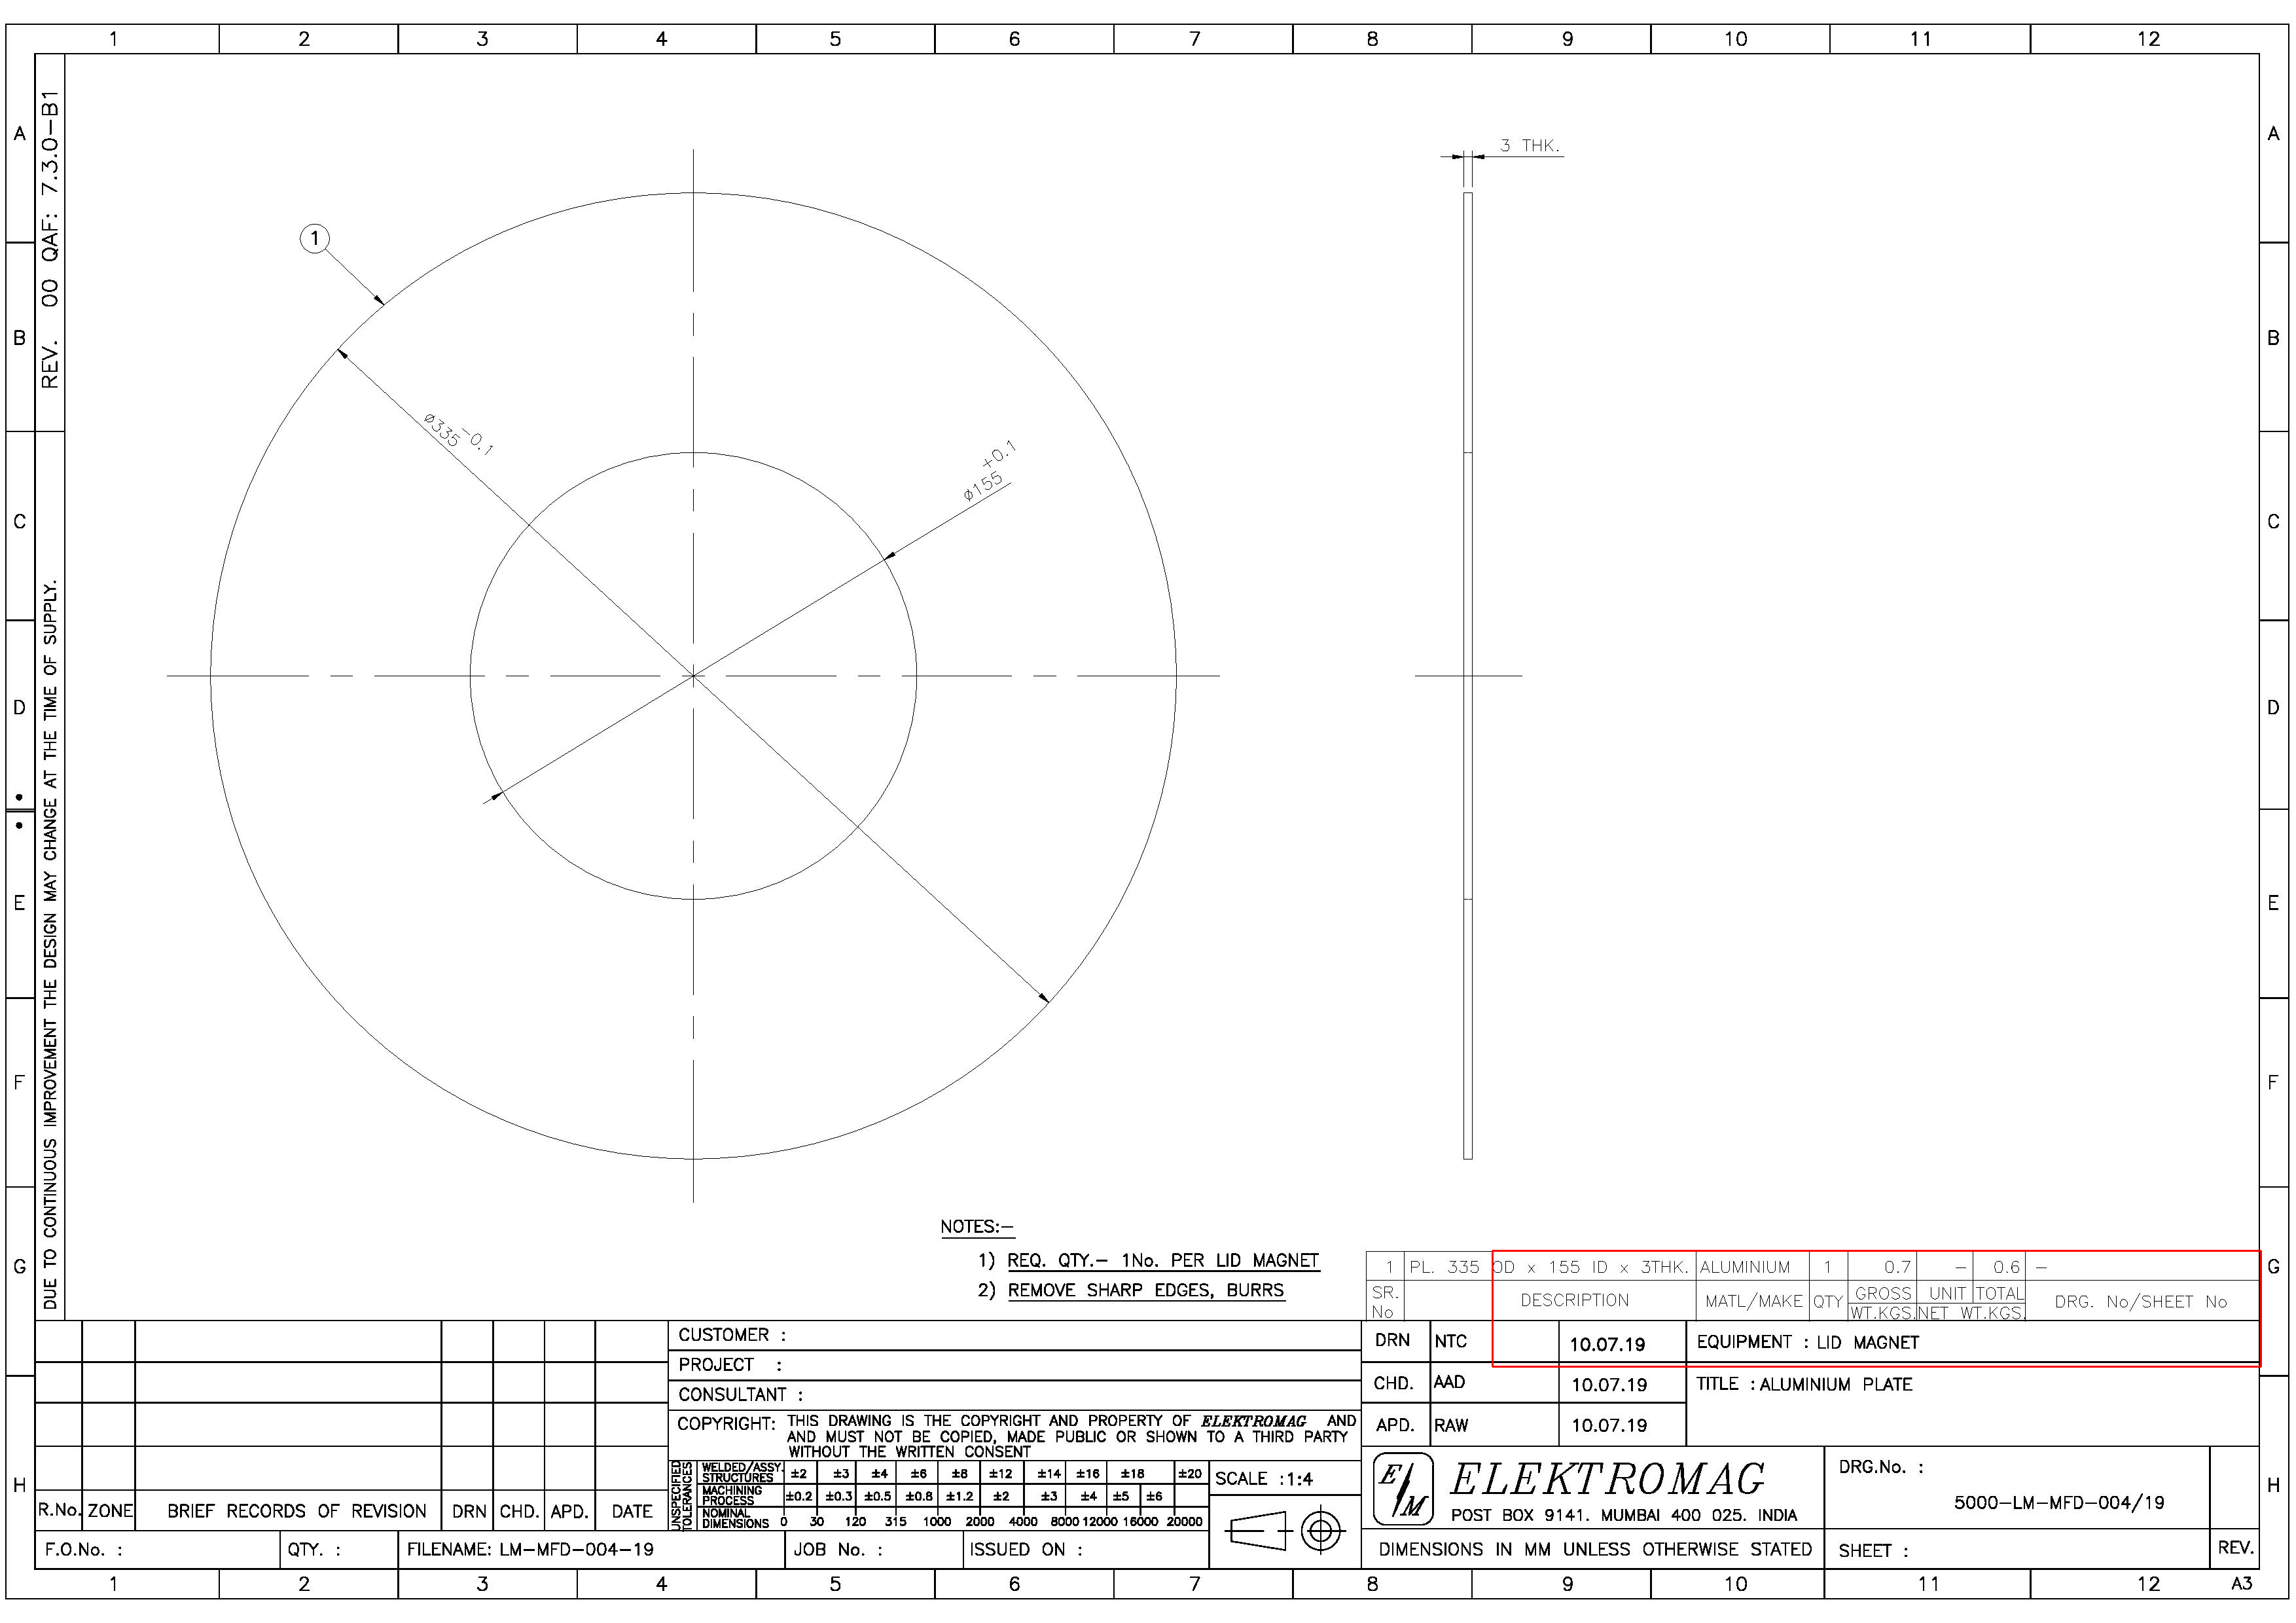

In [10]:
img = 2014
draw_box_pred(img, anchors, target_size, loaded_model_1)


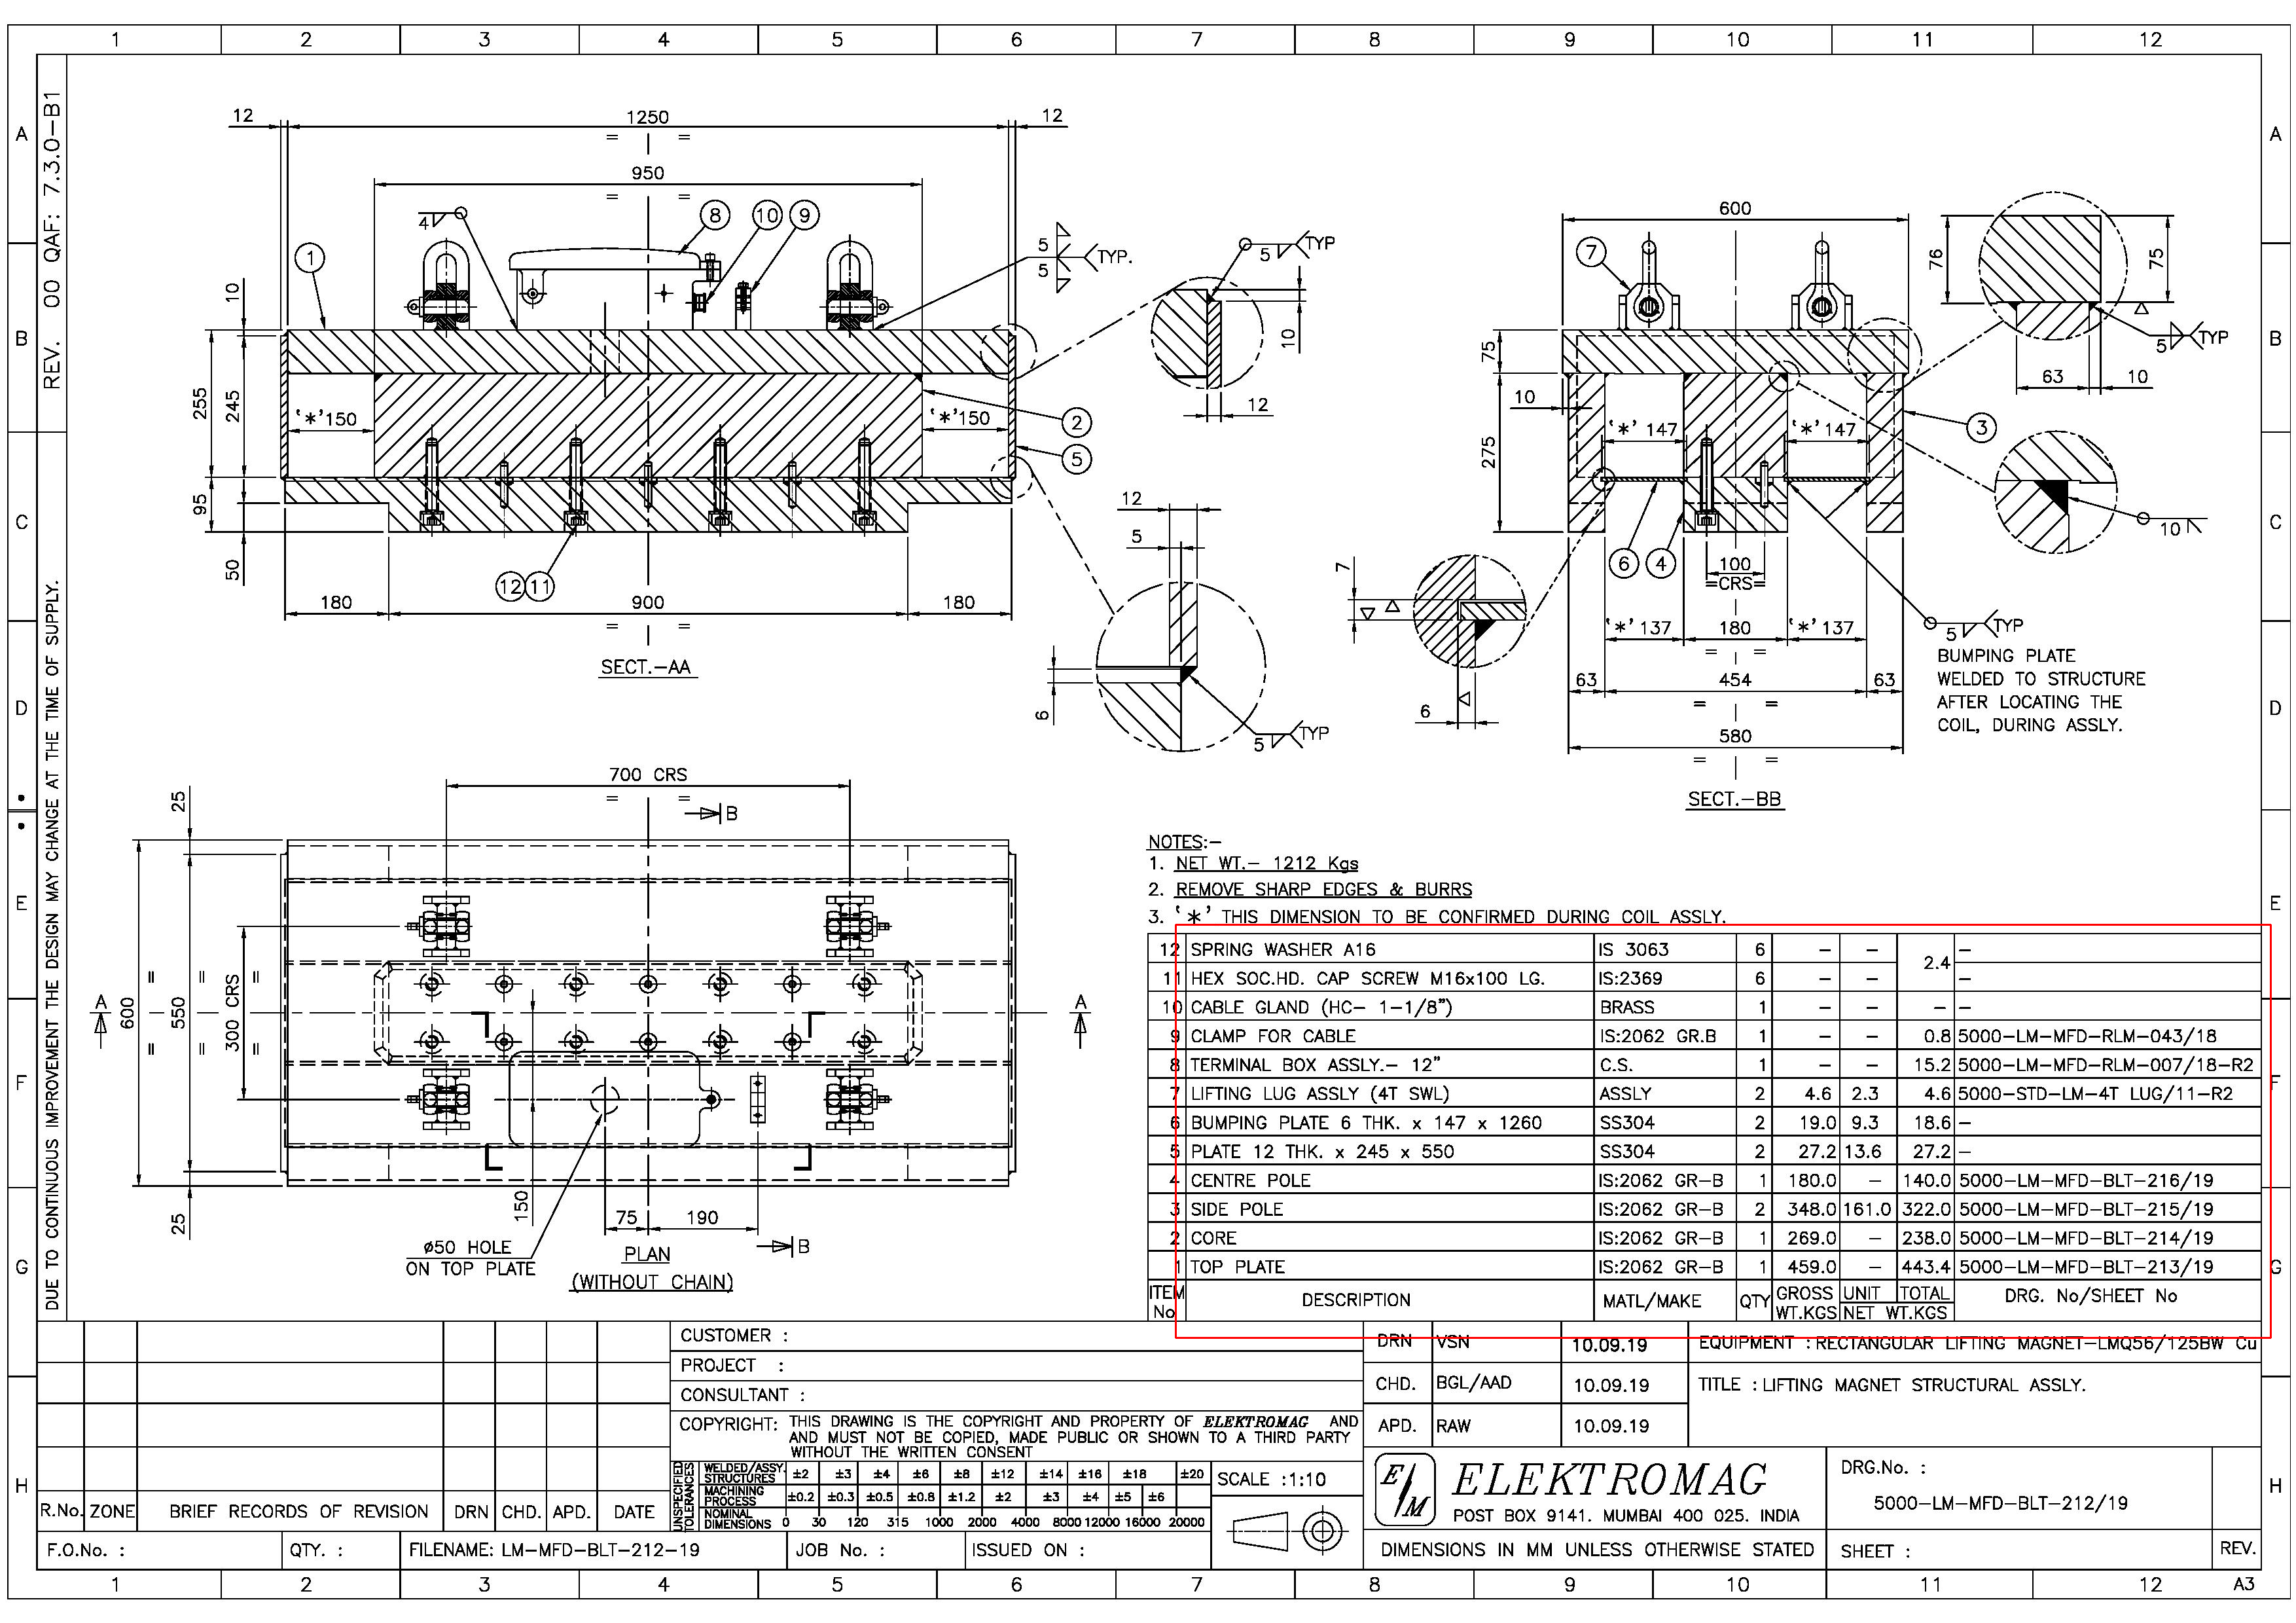

In [36]:
img = 2017
draw_box_pred(img, anchors, target_size, loaded_model_2)


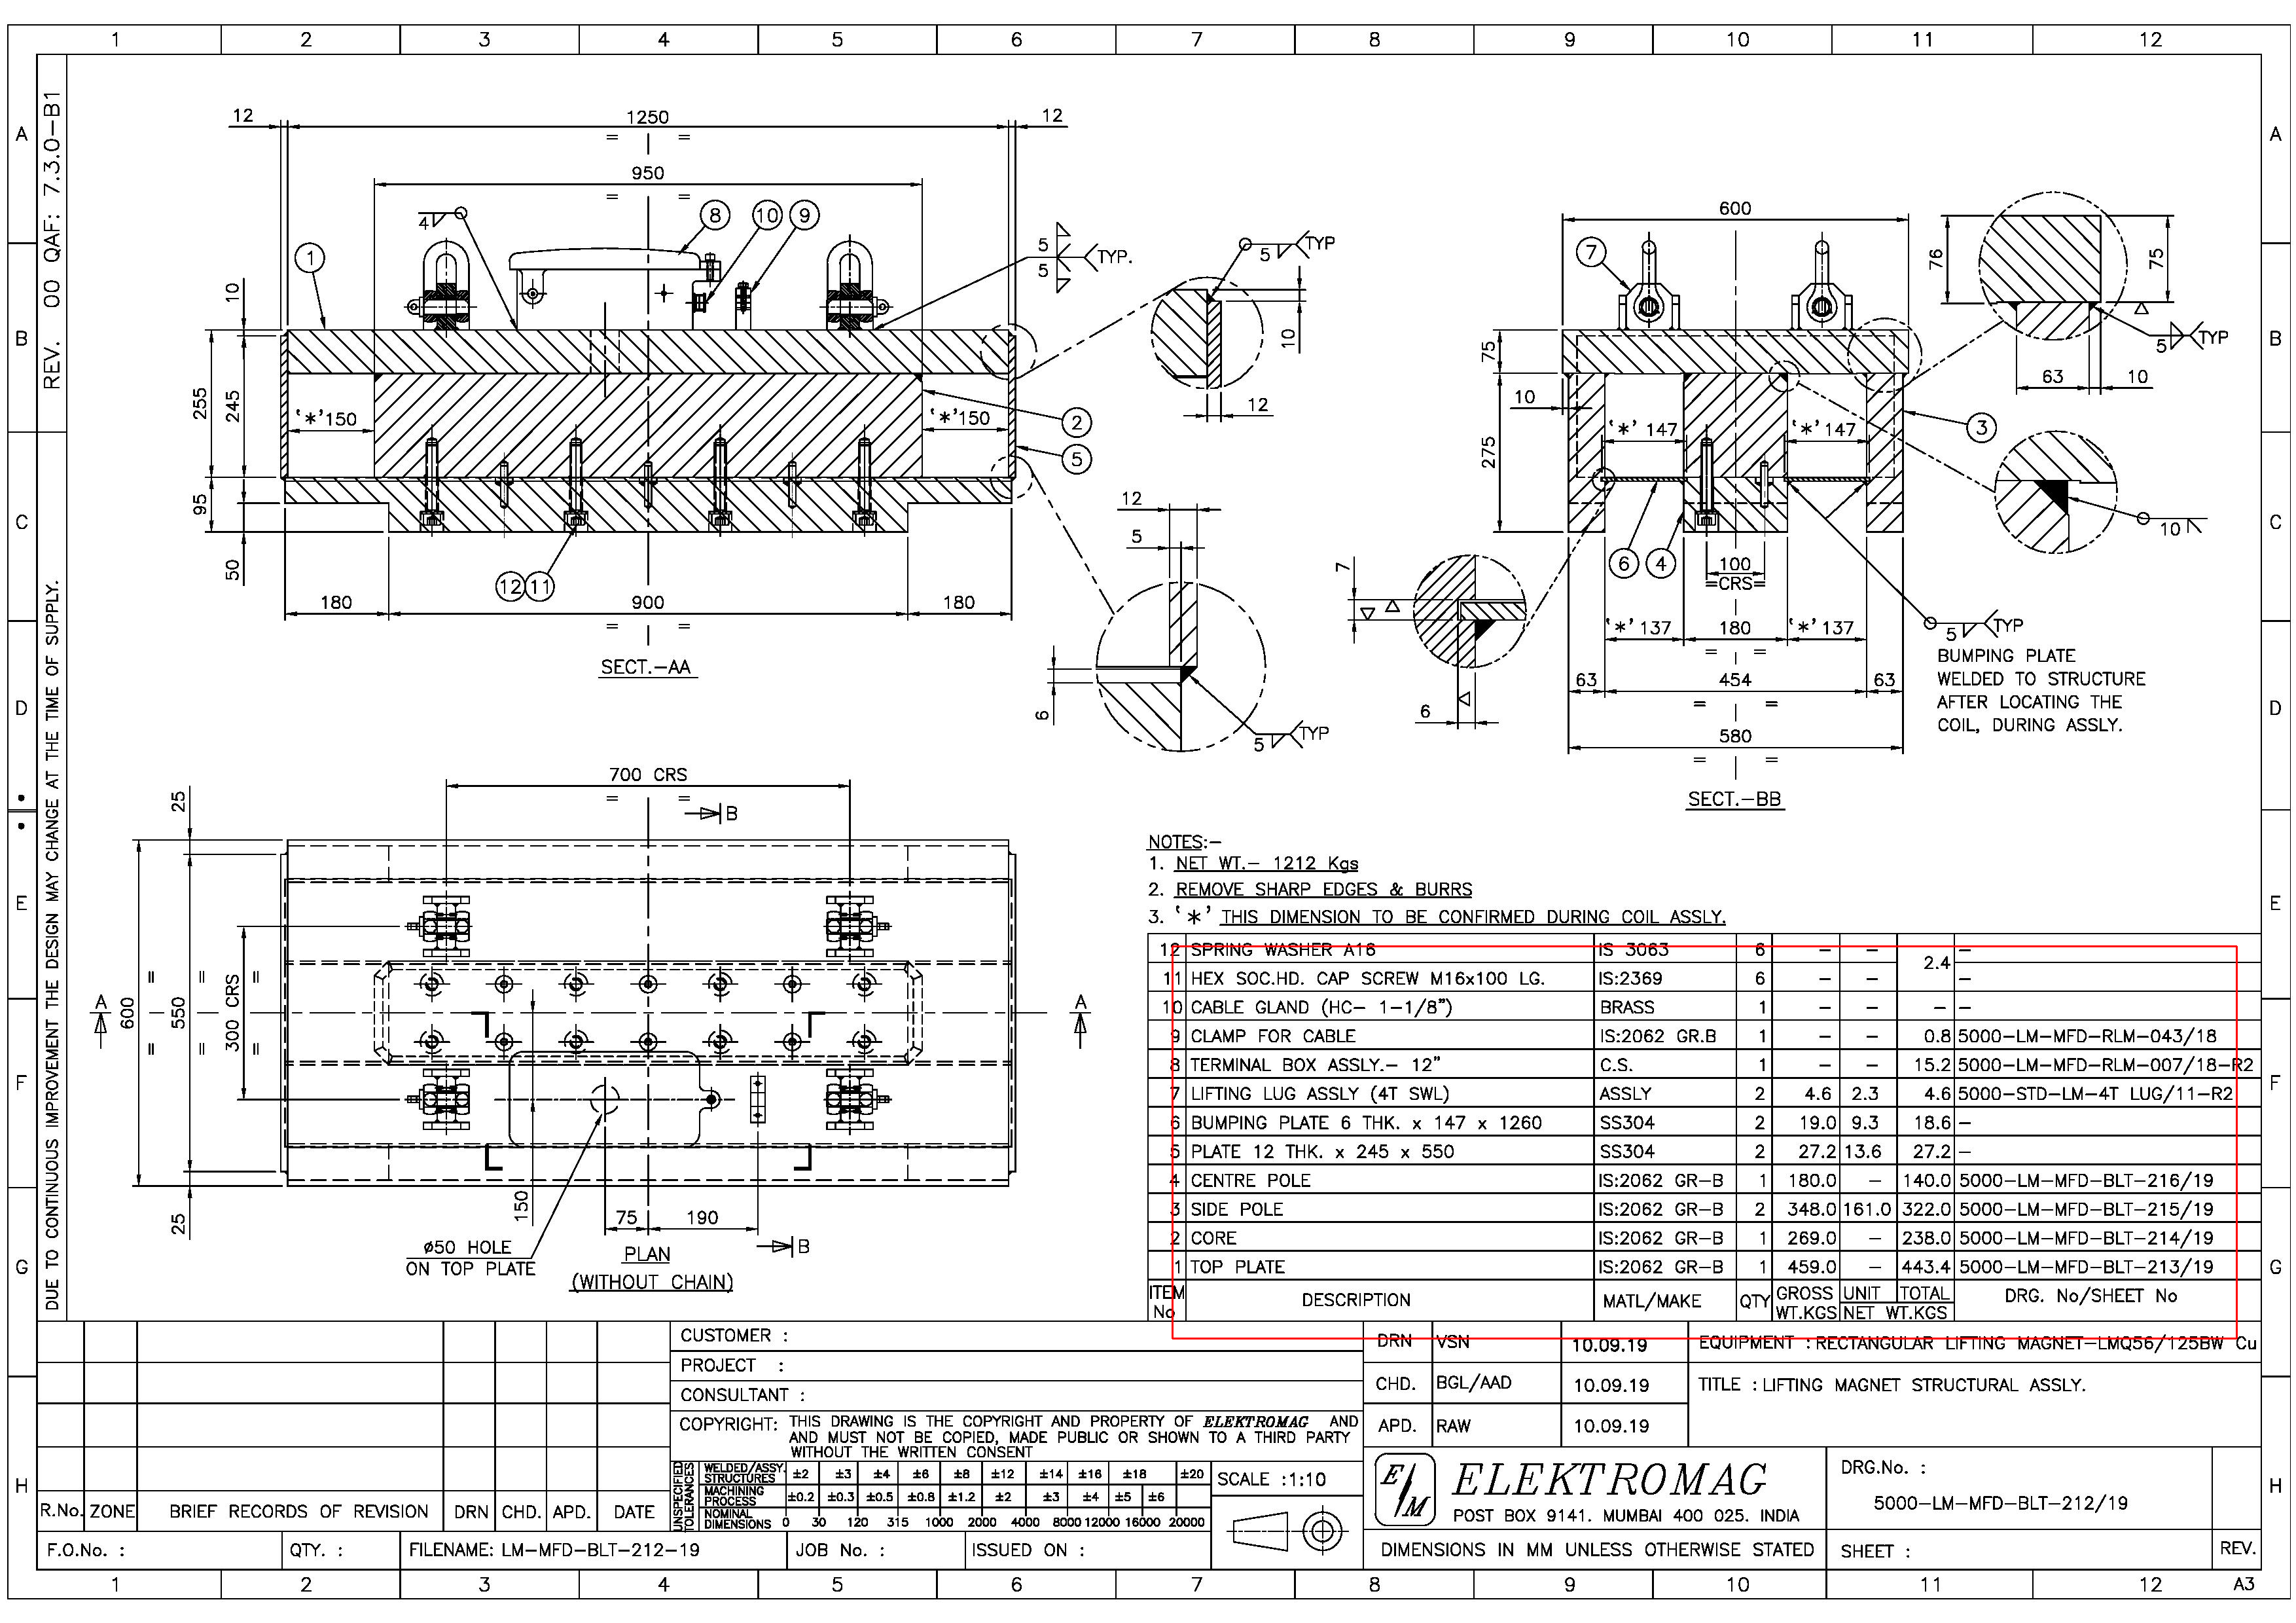

In [34]:
img = 2017
draw_box_pred(img, anchors, target_size, loaded_model_3)


In [31]:
def crop_bom_pred(img_id, anchors, target_size, my_model):

    image_id = str(img_id) + '.jpg'
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id

    
    box_list, _ = actual_box_and_class_1(img_id, anchors, target_size, my_model)

    # print(box_list)  ## box_list is in format xmin, ymin, xmax, ymax

    x = cv2.imread(image_path)

    # By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
    # we need to convert from BGR to RGB format/mode:
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    xx_gray_list = []
    
    for i in range(len(box_list)):

        xx = x[int(box_list[i][1]):int(box_list[i][3]), int(box_list[i][0]):int(box_list[i][2])]
        xx_gray = cv2.cvtColor(xx,cv2.COLOR_BGR2GRAY)
        xx_gray_list.append(xx_gray)

    return xx_gray_list  ## this list is for more than 1 BOM in same drawing
    


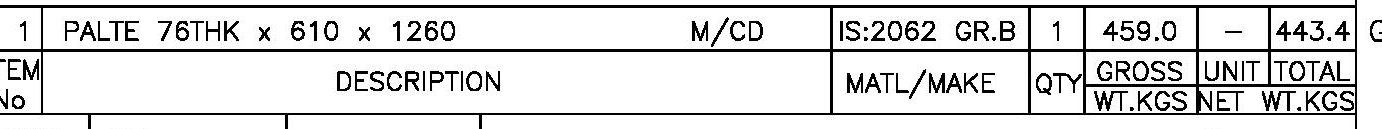

In [32]:
xx_gray_list = crop_bom_pred(img, anchors, target_size, loaded_model_3 )

for i in range(len(xx_gray_list)):

    xx_pil = Image.fromarray(xx_gray_list[i])

    display(xx_pil)

In [30]:
## Find out all individual boxes for subsequent text extraction :

def all_boxes_pred(img_id, anchors, target_size, my_model):
    
    xx_gray_list = crop_bom_pred(img_id, anchors, target_size, my_model)
    
    boxes_list = []
    
    for i in range(len(xx_gray_list)):
    
        ##thresholding the image to a binary image
        thresh,img_bin = cv2.threshold(xx_gray_list[i],0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        #inverting the image 
        img_bin_invert = 255-img_bin

        img_pil = Image.fromarray(img_bin_invert)
        """
        diplay(imgs_pil) 
        """
        # Length(width) of kernel as 100th of total width
        kernel_len = xx_gray_list[i].shape[1]//100

        # Defining a vertical kernel to detect all vertical lines of image 
        ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

        # Defining a horizontal kernel to detect all horizontal lines of image
        hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

        #Use vertical kernel to detect and save the vertical lines in a jpg
        image_1 = cv2.erode(img_bin_invert, ver_kernel, iterations=3)
        vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

        #Use horizontal kernel to detect and save the horizontal lines in a jpg
        image_2 = cv2.erode(img_bin_invert, hor_kernel, iterations=3)
        horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

        # Combine horizontal and vertical lines in a new third image, with both having same weight.
        img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

        # A kernel of 2x2
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        # print('Final kernel = ', kernel)

        img_vh_d = cv2.dilate(img_vh, kernel, iterations=2)

        img_vh_d_pil = Image.fromarray(img_vh_d)
        
        display(img_vh_d_pil)
        
        # Defining the cell boxes

        contours, hierarchy = cv2.findContours(img_vh_d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        boxes = np.zeros((len(contours), 4))

        for i in range(len(contours)):
    
            cnt = contours[i]
            x, y, w, h = cv2.boundingRect(cnt)
            boxes[i, 0] = x
            boxes[i, 1] = y
            boxes[i, 2] = w
            boxes[i, 3] = h

        # print(len(boxes))
        
        boxes_list.append(boxes)
    
    return boxes_list      ## ## in format x, y, w, h


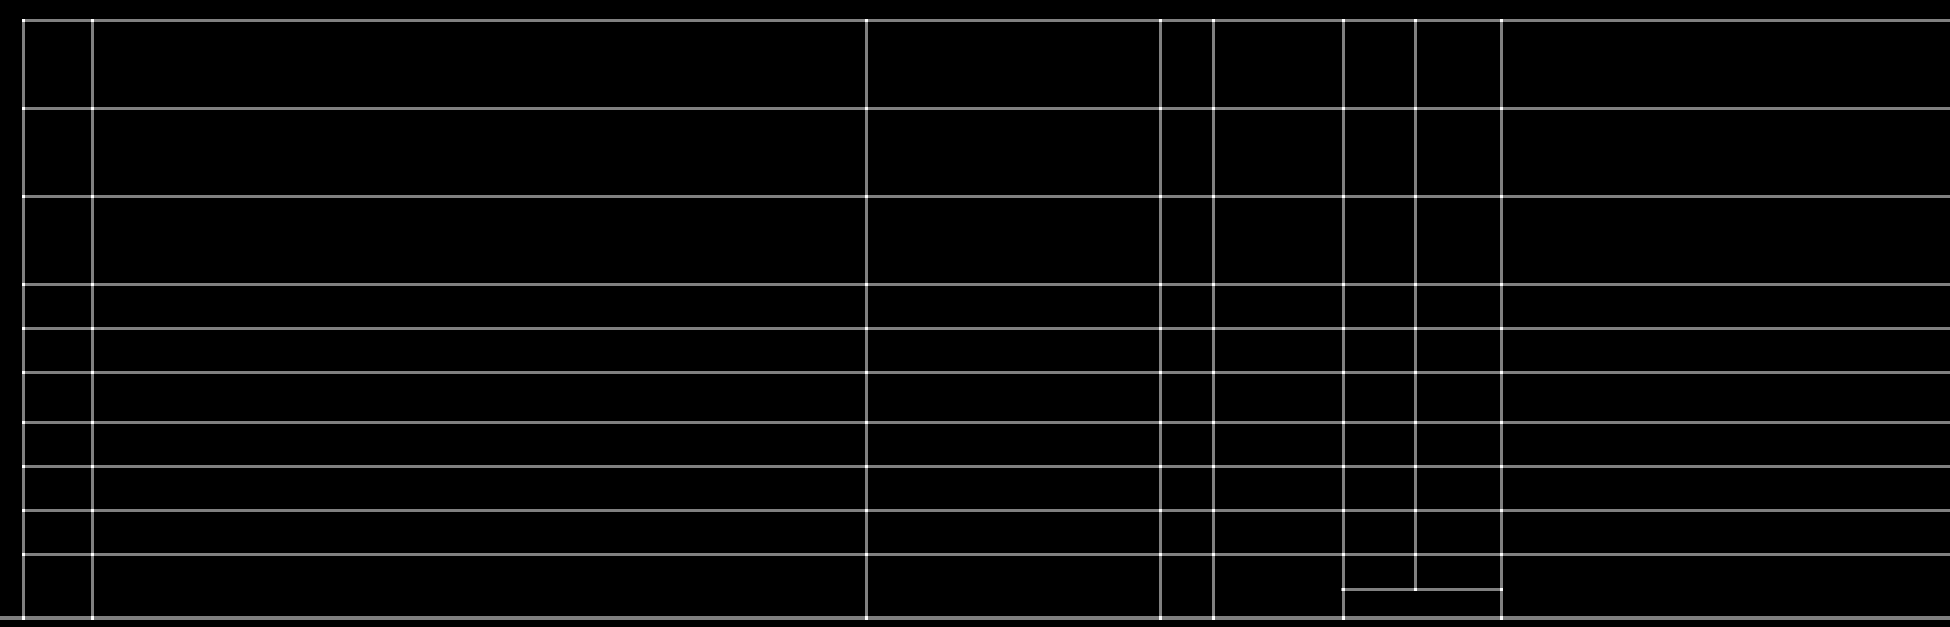

In [63]:
boxes_list = all_boxes_pred(315, anchors, target_size, loaded_model_2)

In [64]:
print(len(boxes_list))
boxes_list

1


[array([[   0.,   19., 1950.,  601.],
        [1344.,  590.,  157.,   27.],
        [1416.,  555.,   85.,   34.],
        [1344.,  555.,   71.,   34.],
        [1214.,  555.,  129.,   62.],
        [1161.,  555.,   52.,   62.],
        [ 867.,  555.,  293.,   62.],
        [  93.,  555.,  773.,   62.],
        [  24.,  555.,   68.,   62.],
        [1416.,  511.,   85.,   43.],
        [1344.,  511.,   71.,   43.],
        [1214.,  511.,  129.,   43.],
        [1161.,  511.,   52.,   43.],
        [ 867.,  511.,  293.,   43.],
        [  93.,  511.,  773.,   43.],
        [  24.,  511.,   68.,   43.],
        [1416.,  467.,   85.,   43.],
        [1344.,  467.,   71.,   43.],
        [1214.,  467.,  129.,   43.],
        [1161.,  467.,   52.,   43.],
        [ 867.,  467.,  293.,   43.],
        [  93.,  467.,  773.,   43.],
        [  24.,  467.,   68.,   43.],
        [1416.,  423.,   85.,   43.],
        [1344.,  423.,   71.,   43.],
        [1214.,  423.,  129.,   43.],
        [116

In [32]:
## Take out header boxe and all other box info for all items separately :

def header_and_item_pred(img_id, anchors, target_size, my_model):
    
    boxes_list = all_boxes_pred(img_id, anchors, target_size, my_model)
    
    col_count_list = []
    header_boxes_list = []
    bom_boxes_list = []
    item_index_width_list = []
    
    for i in range(len(boxes_list)):
    
        boxes_1 = boxes_list[i][1:]   ## removing the line of full box i.e. removing 0th row
        print('++++++++++++++++++++++++')
        print(boxes_1)
        print('=================================')

        ## Find number of columns i.e. max occurance of any y value :

        y_list = boxes_1[:, 1].tolist()   ## since boxes are in x,y,w,h format (output from cv2.boundingRect)

        col_count_array = np.bincount(y_list)  ## no. of occurances of each y-value
        col_count = col_count_array.max()  ## max. no. of occurances of y-value

        print('No. of columns = ', col_count)

        # Now fid the Header row. In drawings, header row is always at the bottom and cv2.boundingRect always starts,
        # after the 1st row which is box of complete BOM, from bottom right

        # So, y value of boxes[1] is the bottom_most-right_most (in this order) cell y value.

        y_bmrm_cell = boxes_1[0][1]

        num_col = y_list.count(y_bmrm_cell)   ## no. of occurances of y_bmrm_cell value

        if num_col == col_count:
    
            y_header_row = y_bmrm_cell
            item_index_width = boxes_1[col_count-1, 2]
            bom_boxes_1 = boxes_1[1:]   ## remove 1st header row for bom consideration
    
        else:
        
            y_next_cell = boxes_1[1][1]

            num_col = y_list.count(y_next_cell)

            if num_col == col_count:
    
                y_header_row = y_next_cell
                item_index_width = boxes_1[col_count, 2]
                bom_boxes_1 = boxes_1[2:]    ## remove 1st 2 rows for bom consideration
                
            else:
            
                y_next_cell = boxes_1[2][1]

                num_col = y_list.count(y_next_cell)

                if num_col == col_count:
    
                    y_header_row = y_next_cell
                    item_index_width = boxes_1[col_count, 2]
                    bom_boxes_1 = boxes_1[3:]    ## remove 1st 3 rows for bom consideration


        header_boxes = boxes_1[boxes_1[:, 1] == y_header_row]
    
        bom_boxes = bom_boxes_1[bom_boxes_1[:, 1] != y_header_row]
        
        col_count_list.append(col_count)
        item_index_width_list.append(item_index_width)
        header_boxes_list.append(header_boxes)
        bom_boxes_list.append(bom_boxes)
    
    return col_count_list, item_index_width_list , header_boxes_list, bom_boxes_list  ## all boxes in x, y, w, h format


In [33]:
## Making the dataframe of BOM :

def bom_df_pred(img_id, anchors, target_size, my_model):
    
    col_count_list, item_index_width_list, header_boxes_list, bom_boxes_list =  header_and_item_pred(img_id, anchors, target_size, my_model)
    
    xx_gray_list = crop_bom_pred(img_id, anchors, target_size, my_model)
    
    ## First find the header info - only one header box will be considered out of list :
    ## It is expected that all header info in one drawing should be same :
    
    
#    print(type(col_count_list), '====', col_count_list)
#    print(type(item_index_width_list), '====', item_index_width_list)
    
#    print('item index width = ', item_index_width_list)
 
    width_list = header_boxes_list[0][:,2]       # to find width of columns
    x_list = header_boxes_list[0][:, 0]          # to find x-co-ordinates  of columns
    
    width_frequency = np.unique(width_list, return_counts=True)[1] # to check how many columns of same width
    
    
    
    print('width_frequency = ', width_frequency)
    
    print('width list = ', width_list)

    
    # Make a list of widths of all columns 
    
    all_width_list = bom_boxes_list[0][:,2].tolist() ## serialised from right to left
    row_count_array = np.bincount(all_width_list)  ## no. of occurances of each width-value
    row_count_apparent = row_count_array.max()
    
    row_count = row_count_apparent // np.max(width_frequency)
    
    print('Row count = ', row_count)
    
    
    aa = header_boxes_list[0].tolist()
    
    
    header_text = []

    for i in range(len(aa)):
    
        yy_gray = xx_gray_list[0][int(aa[i][1]-1):int(aa[i][1] + aa[i][3] - 1), int(aa[i][0]-1):int(aa[i][0] + aa[i][2] - 1)]
    
        thresh, yy_gray_1 = cv2.threshold(yy_gray, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        text = pytesseract.image_to_string(yy_gray_1, config='--psm 6 --oem 2')

        header_text.append(text)
    
    serialised_header_text = header_text[::-1]
    
    print(serialised_header_text)
    
    ## Now find all item or BOM info :
    
    num_item = 0
    bom_text = []
    item_count = 0
    
    for i in range(len(bom_boxes_list)):
        
#        print('bom_boxes_list = ', len(bom_boxes_list))
        
#        print(bom_boxes_list[i])
        
        item_count = item_count + np.count_nonzero(bom_boxes_list[i][:, 2] == item_index_width_list[i])
        
        if width_frequency[0] > 1:        # this shows more cols of same width as index col.
            
            item_count = item_count // width_frequency[0]
            
        print('No. of Items = ', item_count)
            
        y_unique = np.unique(bom_boxes_list[i][:,1])  # serialised from top to bottom
        y_unique = y_unique[::-1]        ## serialised from bottom to top
        
        print(y_unique)

#        num_item = num_item + len(y_unique)

        for j in y_unique:
        
            if j != 0:
    
                bom_sub_text = []
                aa = np.ones((col_count_list[0], 4))
        
            # bb = bom_boxes_list[i]
    
                bb = bom_boxes_list[i][bom_boxes_list[i][:, 1] == j]
        
#            print(bb)
#            print('=============================================')
            
                for k in range(len(width_list)):
                    for l in range(len(bb)):
                        if (bb[l][2]+bb[l][0]) == (width_list[k]+x_list[k]):
                            aa[k, :] = bb[l, :]
                        
#            print(aa)
#            print('=======================================================')

                for k in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
                    yy_gray = xx_gray_list[i][int(aa[k][1]-1):int(aa[k][1] + aa[k][3] - 1), int(aa[k][0]-1):int(aa[k][0] + aa[k][2] - 1)]
        
                    text = pytesseract.image_to_string(yy_gray, config='--psm 6 --oem 3')
            
#                print('k value = ', k, 'text value = ', text)
        
                    bom_sub_text.append(text)
    
                bom_sub_text_rev = bom_sub_text[::-1]
#                print('j = ', j)
#                print('length of sub_text = ', len(bom_sub_text_rev))
                bom_text.append(bom_sub_text_rev)
            
        
            
        #Creating a dataframe of the generated OCR list
    arr = np.array(bom_text)
             
    dataframe = pd.DataFrame(arr.reshape(row_count, col_count_list[0]), columns = serialised_header_text)
    
    return dataframe


In [42]:
df = bom_df_pred(544, anchors, target_size, loaded_model_2)

df.head()

NameError: name 'bom_df_pred' is not defined

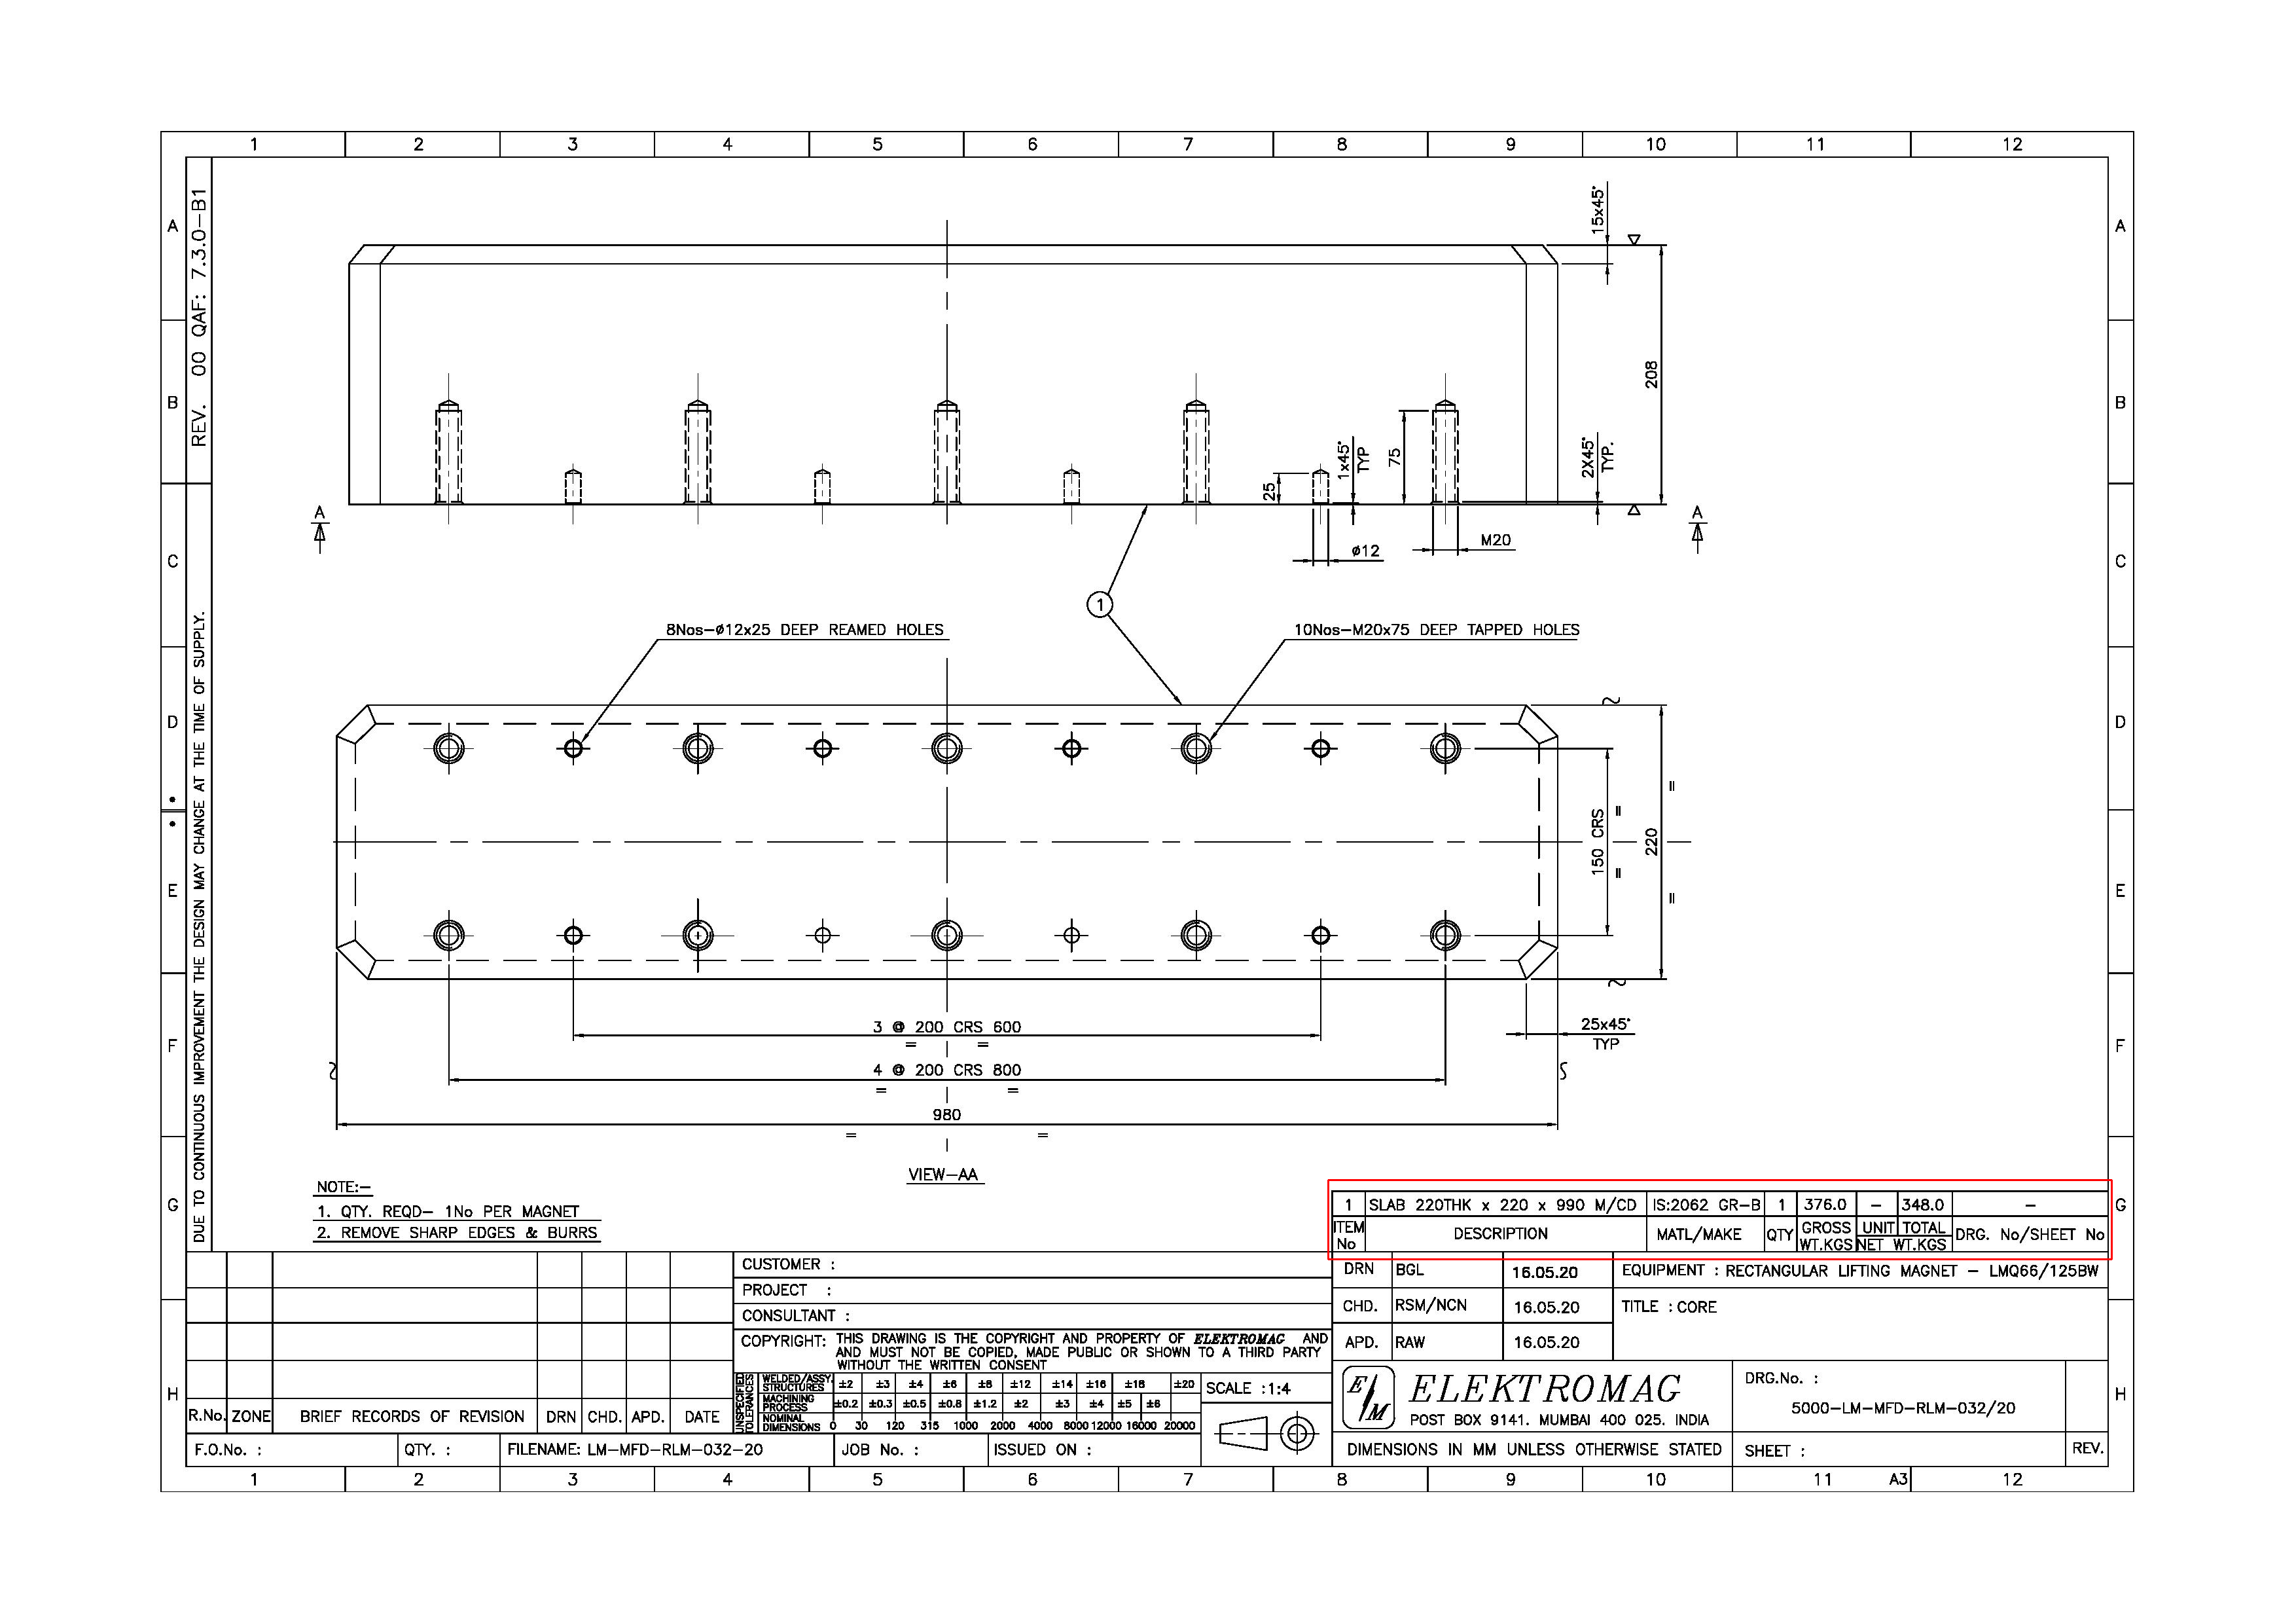

In [37]:
anchors = anchors_wrt_target

draw_box_pred(304, anchors, target_size, loaded_model_2)


In [50]:
print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images
print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts())

Number of unique images =  324
Number of classes in diff. categories =  item    324
Name: obj_class, dtype: int64


In [73]:
# Train and Test split

data_train, data_val = train_test_split(all_image_line, train_size = 0.90 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
print(num_all_bbox, num_bb_train, num_bb_val)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


324 291 33


In [82]:
# calculating anchors from true boundary boxes :

def iou_kmeans(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou = intersection / (box_area + cluster_area - intersection)

    return iou

def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]


    while True:
        for row in range(rows):
            distances[row] = 1 - iou_kmeans(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [87]:
# Finding out anchors :
## Firstly, converting true boundary box width, height to width & height with respect to target image :
## finaly find anchors. Anchors here are in absolute size w.r.t. target image but not as % of target image or 
## as multiple of unit grids.

num_all_bb = len(r_new_data) # if no. of bboxes varies for images, this formula should be used 

anchors_wrt_target = np.zeros((3,2))

# num_all_bb = len(all_image_line) * len(all_image_line[0][2])  ## from all image line data, this formula to be used if no. of bboxes are same for all images

b_box_wrt_target = np.zeros((num_all_bb,2))

for i in range(num_all_bb):
    
    image_w = r_new_data['img_wd'][i]
    image_h = r_new_data['img_ht'][i]

    x_ratio = target_w / image_w 
    y_ratio = target_h / image_h

    # x_ratio = 1.    ## since we shall only pad the images 
    # y_ratio = 1.    ## since we shall only pad the images
    
    anchor_w = r_new_data['width'][i] * x_ratio
    anchor_h = r_new_data['height'][i] * y_ratio
    b_box_wrt_target[i, 0] = anchor_w
    b_box_wrt_target[i, 1] = anchor_h
    
anchors_wrt_target = kmeans(b_box_wrt_target, num_anchors)

print(anchors_wrt_target.shape)
print(anchors_wrt_target)     ## anchors wrt target image in abs. value and in format width, height


(3, 2)
[[241.69213227  75.04961678]
 [224.44697834  31.88382412]
 [249.92474344 149.85397338]]


In [76]:
nchors_wrt_target = [328.84834664, 197.17628076, 295.32497149, 41.95240016, 318.01596351, 98.74949576]
anchors_wrt_target = np.reshape(anchors_wrt_target, [3,2])
anchors_wrt_target

array([[328.84834664, 197.17628076],
       [295.32497149,  41.95240016],
       [318.01596351,  98.74949576]])

In [84]:
## Pre-processing the original data to get y_true :

def process_box(ori_boxes, ori_img_width, ori_img_height, labels, target_size, class_num, anchors):
    '''
    Generate the y_true label, i.e. the ground truth feature_map.
    params:
        boxes: [N, 5] shape, float32 dtype. `x_min, y_min, x_max, y_mix, mixup_weight`.
        labels: [N] shape, int64 dtype.
        class_num: int64 num.
        anchors: [3,2] shape, float32 dtype.
    '''
    
    img_width = ori_img_width
    img_height = ori_img_height
    boxes = ori_boxes           ## boxes in format xmin, ymin, xmax, ymax
  
    x_ratio = target_size[1] / img_width
    y_ratio = target_size[0] / img_height
    

    
    
    
    boxes_wrt_target = np.zeros((1,4))
    box_centers_target = np.zeros((1,2))

    boxes_wrt_target[:,0] = boxes[:,0] * x_ratio  # xmin absolute value wrt target image
    boxes_wrt_target[:,1] = boxes[:,1] * y_ratio  # ymin absolute value wrt target image
    boxes_wrt_target[:,2] = boxes[:,2] * x_ratio  # xmax absolute value wrt target image
    boxes_wrt_target[:,3] = boxes[:,3] * y_ratio  # ymax absolute value wrt target image
    
    # In above, boxes_wrt_target shape is (5, 4), now this will be taken to (5. 5) by adding 1 at end
#    boxes_wrt_target = np.concatenate((boxes_wrt_target, np.full(shape=(boxes_wrt_target.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)
    box_centers_target = (boxes_wrt_target[:, 0:2] + boxes_wrt_target[:, 2:4]) / 2  ## centers wrt target, abs values
    
    box_sizes = boxes[:, 2:4] - boxes[:, 0:2]  #xmax-xmin = width and ymax-ymin = height wrt original image
    box_sizes[:,0] = box_sizes[:,0] * x_ratio  # width w.r.t target image in absolute value
    box_sizes[:,1] = box_sizes[:,1] * y_ratio  # width w.r.t target image in absolute value
    
#    y_true_13 = np.zeros((target_size[1] // 32, target_size[0] // 32, 3, 6 + class_num), np.float32)
    y_true_13 = np.zeros((target_size[1] // 32, target_size[0] // 32, 3, 5 + class_num), np.float32)

#    y_true = [y_true_13]
    
    box_sizes = np.expand_dims(box_sizes, 1)
    mins = np.maximum(- box_sizes / 2, - anchors / 2)
    maxs = np.minimum(box_sizes / 2, anchors / 2)
    whs = maxs - mins

    iou = (whs[:, :, 0] * whs[:, :, 1]) / (
                box_sizes[:, :, 0] * box_sizes[:, :, 1] + anchors[:, 0] * anchors[:, 1] - whs[:, :, 0] * whs[:, :,
                                                                                                         1] + 1e-10)
    best_match_idx = np.argmax(iou, axis=1)
    
#    print(best_match_idx)

    anchor_mask = np.zeros((target_size[1] // 32, target_size[0] // 32, 3))

    grid_stride = 32  ## = targetsize / no. of grid cells
    
    for i, idx in enumerate(best_match_idx):

        x = int(np.floor(box_centers_target[i, 0] / grid_stride))
        y = int(np.floor(box_centers_target[i, 1] / grid_stride))
        k = int(idx)
        c = int(labels[i])

        print(x, y, k, c)
        

# Very Imp : Now preparing y_true: all values x_center, y_cemter, width & height are being taken to % of target image
        
        y_true_13[y, x, k, :2] = box_centers_target[i] / target_size[0] #since target_size[0] = target_size[1]
        y_true_13[y, x, k, 2:4] = box_sizes[i] / target_size[0]
        y_true_13[y, x, k, 4] = 1.
        y_true_13[y, x, k, 5 + c] = 1.
#        y_true[0][y, x, k, -1] = boxes_wrt_target[i, -1]
        anchor_mask[y, x, k] = 1
#        print(y_true_13[y,x])

    return y_true_13, anchor_mask  ## all data are w.r.to target image in % of target image and NOT w,r,t, grid cells


In [78]:
## Single image-wise image/boundary box preprocessing:

def parse_data(line, class_num, target_size, anchors):   ## (mode, letterbox_resize):
    '''
    param:
        line: a line from the training/test txt file
        class_num: totol class nums.
        target_size: the size of image to be resized to. [width, height] format.
        anchors: anchors.
        mode: 'train' or 'val'. When set to 'train', data_augmentation will be applied.
        letterbox_resize: whether to use the letterbox resize, i.e., keep the original aspect ratio in the resized image.
    '''
    
    img_idx, pic_path, boxes, labels,img_width, img_height = line  # boxes in format xmin, ymin, xmax, ymax
    img = cv2.imread(pic_path)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    
#    img_resized = unsharp_mask(img_resized)
    
#    img_resized, pad_top, pad_bottom = pad_images_to_same_size(img)
    
#    image_height = img_height + pad_top + pad_bottom
    
    # expand the 2nd dimension, mix up weight default to 1.
#    boxes = np.concatenate((boxes, np.full(shape=(boxes.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)

    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB).astype(np.float32)

    # the input of yolo_v3 should be in range 0~1, lets change to -0.5 to +0.5
    img_resized = (img_resized - 127.5)/ 255.

    y_true_13, anchor_mask = process_box(boxes, img_width, img_height, labels, target_size, class_num, anchors)

    return img_idx, img_resized, y_true_13, anchor_mask


In [19]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [88]:
## Making the data ready for entering into network :

anchors = anchors_wrt_target
image_index = []
image_resized = []
image_y_true = []
image_anchor_mask = []

for i in range(len(data_train)):

    line = data_train[i]
    
    img_idx, img_resized, y_true, anchor_mask = parse_data(line, class_num, target_size, anchors)
    
    
    image_index.append(img_idx)
    image_resized.append(img_resized)
    image_y_true.append(y_true)
    image_anchor_mask.append(anchor_mask)
    print('train img_index. = ', img_idx)
    print('train sl. no. = ', i)
    print('=============================')
train_image_index = image_index
X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)
train_anchor_mask = np.array(image_anchor_mask).astype(np.float32)

image_index = []
image_resized = []
image_y_true = []
image_anchor_mask = []

for i in range(len(data_val)):
    line = data_val[i]
    
    
    img_idx, img_resized, y_true, anchor_mask = parse_data(line, class_num, target_size, anchors)
    
    image_index.append(img_idx)
    image_resized.append(img_resized)
    image_y_true.append(y_true)
    image_anchor_mask.append(anchor_mask)
    print('val img_index. = ', img_idx)
    print('val sl. no. = ', i)
    print('=============================')
    
val_image_index = image_index
X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)
val_anchor_mask = np.array(image_anchor_mask).astype(np.float32)

image_index = []
image_resized = []
image_y_true = []


14 14 0 0
train img_index. =  60
train sl. no. =  0
5 14 2 0
train img_index. =  175
train sl. no. =  1
14 14 1 0
train img_index. =  21
train sl. no. =  2
13 13 0 0
train img_index. =  82
train sl. no. =  3
14 15 1 0
train img_index. =  152
train sl. no. =  4
15 13 2 0
train img_index. =  167
train sl. no. =  5
14 13 0 0
train img_index. =  285
train sl. no. =  6
5 15 0 0
train img_index. =  197
train sl. no. =  7
14 13 2 0
train img_index. =  139
train sl. no. =  8
14 13 0 0
train img_index. =  231
train sl. no. =  9
15 14 0 0
train img_index. =  306
train sl. no. =  10
15 14 0 0
train img_index. =  259
train sl. no. =  11
14 13 0 0
train img_index. =  331
train sl. no. =  12
13 14 2 0
train img_index. =  55
train sl. no. =  13
5 13 2 0
train img_index. =  173
train sl. no. =  14
14 15 1 0
train img_index. =  5
train sl. no. =  15
15 14 1 0
train img_index. =  234
train sl. no. =  16
14 13 0 0
train img_index. =  126
train sl. no. =  17
14 14 0 0
train img_index. =  146
train sl. no.

14 13 0 0
train img_index. =  98
train sl. no. =  101
16 14 1 0
train img_index. =  225
train sl. no. =  102
14 14 0 0
train img_index. =  162
train sl. no. =  103
14 14 0 0
train img_index. =  38
train sl. no. =  104
14 13 0 0
train img_index. =  330
train sl. no. =  105
15 14 0 0
train img_index. =  251
train sl. no. =  106
14 13 0 0
train img_index. =  117
train sl. no. =  107
14 14 1 0
train img_index. =  293
train sl. no. =  108
14 14 1 0
train img_index. =  128
train sl. no. =  109
14 13 2 0
train img_index. =  145
train sl. no. =  110
14 12 2 0
train img_index. =  244
train sl. no. =  111
15 14 1 0
train img_index. =  119
train sl. no. =  112
13 12 2 0
train img_index. =  48
train sl. no. =  113
14 14 1 0
train img_index. =  329
train sl. no. =  114
14 13 2 0
train img_index. =  143
train sl. no. =  115
14 11 2 0
train img_index. =  237
train sl. no. =  116
15 14 0 0
train img_index. =  249
train sl. no. =  117
14 14 1 0
train img_index. =  288
train sl. no. =  118
14 13 0 0
tra

5 15 0 0
train img_index. =  176
train sl. no. =  200
14 15 1 0
train img_index. =  267
train sl. no. =  201
6 15 1 0
train img_index. =  86
train sl. no. =  202
15 14 2 0
train img_index. =  22
train sl. no. =  203
14 14 1 0
train img_index. =  287
train sl. no. =  204
14 15 0 0
train img_index. =  66
train sl. no. =  205
5 15 0 0
train img_index. =  83
train sl. no. =  206
14 14 1 0
train img_index. =  300
train sl. no. =  207
5 15 0 0
train img_index. =  189
train sl. no. =  208
15 14 0 0
train img_index. =  256
train sl. no. =  209
14 15 1 0
train img_index. =  39
train sl. no. =  210
14 14 0 0
train img_index. =  122
train sl. no. =  211
14 15 1 0
train img_index. =  121
train sl. no. =  212
14 14 0 0
train img_index. =  274
train sl. no. =  213
14 14 0 0
train img_index. =  17
train sl. no. =  214
5 15 0 0
train img_index. =  178
train sl. no. =  215
5 14 2 0
train img_index. =  212
train sl. no. =  216
5 14 0 0
train img_index. =  282
train sl. no. =  217
14 14 0 0
train img_ind

MemoryError: Unable to allocate 1.20 GiB for an array with shape (291, 608, 608, 3) and data type float32

In [68]:
def make_yolov3_model():
    input_image = Input(shape=(800, 800, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

    final = Reshape((grid_y_axis,grid_x_axis,num_anchors,info))(yolo_106)

    model = Model(input_image, final)

    return model

In [69]:
input_size = (target_w, target_h, 3)


my_model_1 = make_yolov3_model()

print(my_model_1.summary())


Model: "functional_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 800, 800, 32) 864         input_26[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 800, 800, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 800, 800, 32) 0           bnorm_0[0][0]                    
______________________________________________________________________________________

In [1]:
def xywh_to_x1y1x2y2(box):
    xy = box[..., 0:2]
    wh = box[..., 2:4]

    x1y1 = xy - wh / 2
    x2y2 = xy + wh / 2

    y_box = K.concatenate([x1y1, x2y2], axis=-1)
    return y_box

def broadcast_iou(box_a, box_b):
    """
    calculate iou between box_a and multiple box_b in a broadcast way
    inputs: box_a: a tensor full of boxes, eg. (B, N, 4), box is in x1y1x2y2
            box_b: another tensor full of boxes, eg. (B, M, 4)
    """

    # (B, N, 1, 4)
    box_a = tf.expand_dims(box_a, -2)
    # (B, 1, M, 4)
    box_b = tf.expand_dims(box_b, -3)
    # (B, N, M, 4)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_a), tf.shape(box_b))

    # (B, N, M, 4)
    # (B, N, M, 4)
    box_a = tf.broadcast_to(box_a, new_shape)
    box_b = tf.broadcast_to(box_b, new_shape)

    # (B, N, M, 1)
    al, at, ar, ab = tf.split(box_a, 4, -1)
    bl, bt, br, bb = tf.split(box_b, 4, -1)

    # (B, N, M, 1)
    left = tf.math.maximum(al, bl)
    right = tf.math.minimum(ar, br)
    top = tf.math.maximum(at, bt)
    bot = tf.math.minimum(ab, bb)

    # (B, N, M, 1)
    iw = tf.clip_by_value(right - left, 0, 1)
    ih = tf.clip_by_value(bot - top, 0, 1)
    i = iw * ih

    # (B, N, M, 1)
    area_a = (ar - al) * (ab - at)
    area_b = (br - bl) * (bb - bt)
    union = area_a + area_b - i

    # (B, N, M)
    iou = tf.squeeze(i / (union + 1e-7), axis=-1)

    return iou

## https://github.com/ethanyanjiali/deep-vision/blob/master/YOLO/tensorflow/yolov3.py#L213

def calc_ignore_mask(ignore_thresh, true_box, pred_box):
    
        # YOLOv3:
        # "If the bounding box prior is not the best but does overlap a ground
        # truth object by more than some threshold we ignore the prediction,
        # following [17]. We use the threshold of .5."
        # calculate the iou for each pair of pred bbox and true bbox, then find the best among them

        # (None, 13, 13, 3, 4)
        
        true_box_reorganised = xywh_to_x1y1x2y2(true_box)  # reorganised to x1, y1, x2, y2
        pred_box_reorganised = xywh_to_x1y1x2y2(pred_box)
        
        true_box_shape = tf.shape(true_box_reorganised)  
        # (None, 13, 13, 3, 4)
        pred_box_shape = tf.shape(pred_box_reorganised)  
        # (None, 507, 4)
        true_box_reorganised = tf.reshape(true_box_reorganised, [true_box_shape[0], -1, 4])
        # sort true_box to have non-zero boxes rank first
        true_box_reorganised = tf.sort(true_box_reorganised, axis=1, direction="DESCENDING")
        # (None, 100, 4)
        # only use maximum 100 boxes per groundtruth to calcualte IOU, otherwise
        # GPU emory comsumption would explode for a matrix like (16, 52*52*3, 52*52*3, 4)
        true_box_reorganised = true_box_reorganised[:, 0:100, :]
        # (None, 507, 4)
        pred_box_reorganised = tf.reshape(pred_box_reorganised, [pred_box_shape[0], -1, 4])

        # https://github.com/dmlc/gluon-cv/blob/06bb7ec2044cdf3f433721be9362ab84b02c5a90/gluoncv/model_zoo/yolo/yolo_target.py#L198
        # (None, 507, 507)
        iou = broadcast_iou(pred_box_reorganised, true_box_reorganised)
        # (None, 507)
        best_iou = tf.reduce_max(iou, axis=-1)
        # (None, 13, 13, 3)
        best_iou = tf.reshape(best_iou, [pred_box_shape[0], pred_box_shape[1], pred_box_shape[2], pred_box_shape[3]])
        # ignore_mask = 1 => don't ignore
        # ignore_mask = 0 => should ignore
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
        # (None, 13, 13, 3, 1)
        ignore_mask = tf.expand_dims(ignore_mask, axis=-1)
        
        return ignore_mask

In [2]:
anchors = np.reshape(anchors_wrt_target, [1,1,1,3,2])

NameError: name 'np' is not defined

In [3]:
## made on 16/7/2020 at 8:48 pm

from functools import partial

# anchors = np.reshape(anchors_wrt_target, [1,1,1,3,2])

def my_custom_loss(y_true, y_pred):
    
    def pre_loss(my_custom_loss, anchors):
        
        num_anchors = len(anchors)
        num_classes = 1
        ignore_thresh = 0.5
        grid_size = [25., 25.]
        grid_stride = 800. / grid_size[0]
        batch_shape = y_pred.get_shape()
#        batch_size = batch_shape[0]
        batch_size = 8.
    
        scaled_anchors = anchors / grid_stride
    
        Lambda_Coord = 5.0
        Lambda_no_obj = 0.5
    
        grid_x = np.arange(grid_size[1])
        grid_y = np.arange(grid_size[0])
    
        a = np.array(np.meshgrid(grid_x, grid_y))
        b = np.array(np.meshgrid(grid_x, grid_y))
        c = np.array(np.meshgrid(grid_x, grid_y))
        d = np.concatenate((a,b,c), axis = 0)
        e = d.transpose(2, 1, 0)
        grid_final = np.reshape(e,[1,25,25,3,2])
        grid_final[..., [0,1]] = grid_final[..., [1,0]]
    
        tot_loss = tf.zeros(1, dtype='float32')

        obj_mask = y_true[..., 4:5]

## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

        pred_box_xy = K.sigmoid(y_pred[..., :2]) + grid_final  # this gives x & y in no. of cells. x & y w.r.t. target
                                                               # image = (x & y in no. of cells) / no. of cells
        pred_box_xy_wrt_target_image = (pred_box_xy * grid_stride) / 608.
        true_box_xy_wrt_target_image = y_true[..., :2]

        xy_arr = Lambda_Coord * K.square(true_box_xy_wrt_target_image - pred_box_xy_wrt_target_image)
    
        xy_loss = K.sum(xy_arr * obj_mask) / batch_size
    
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
                       
        pred_box_wdht = K.exp(y_pred[..., 2:4]) * (anchors / 608.)
    
        true_box_wdht = y_true[..., 2:4]
    
        wh_arr = Lambda_Coord * K.square(true_box_wdht - pred_box_wdht)
    
        wh_loss = K.sum(wh_arr * obj_mask) / batch_size
    
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
        
        pred_obj_mask = K.sigmoid(y_pred[..., 4:5])  # shape = 28, 17, 17, 3, 1
       
        true_box_wrt_ti = K.concatenate([true_box_xy_wrt_target_image, true_box_wdht], axis = -1)  ## in x,y,w,h format
        pred_box_wrt_ti = K.concatenate([pred_box_xy_wrt_target_image, pred_box_wdht], axis = -1)  ## in x,y,w,h format
    
        ignore_mask = calc_ignore_mask(ignore_thresh, true_box_wrt_ti, pred_box_wrt_ti)
        
#        bce = tf.keras.losses.BinaryCrossentropy()        
#        obj_loss = K.sum(bce(obj_mask, pred_obj_mask) * obj_mask)

        obj_loss_arr = K.square(obj_mask - pred_obj_mask)
        obj_loss = K.sum(obj_loss_arr * obj_mask) / batch_size
    
        no_obj_mask = 1. - obj_mask
                
        noobj_loss_arr = Lambda_no_obj * K.square(obj_mask - pred_obj_mask)
        noobj_loss = K.sum(noobj_loss_arr * no_obj_mask * ignore_mask) / batch_size
        
        
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        true_classes = y_true[..., 5:6]
    
        pred_classes = K.sigmoid(y_pred[..., 5:6])
        
#        cce = tf.keras.losses.CategoricalCrossentropy()
    
#        class_loss = K.sum(bce(true_classes, pred_classes) * obj_mask)

        class_loss_arr = K.square(true_classes - pred_classes)
        class_loss = K.sum(class_loss_arr * obj_mask) / batch_size
        
#        tot_loss = xy_loss + wh_loss + obj_loss + noobj_loss + class_loss

        tot_loss = xy_loss + wh_loss + obj_loss + noobj_loss + class_loss

        
        return tot_loss
    
    loss = pre_loss(my_custom_loss, anchors)
    
    return loss
    


(185, 1234)


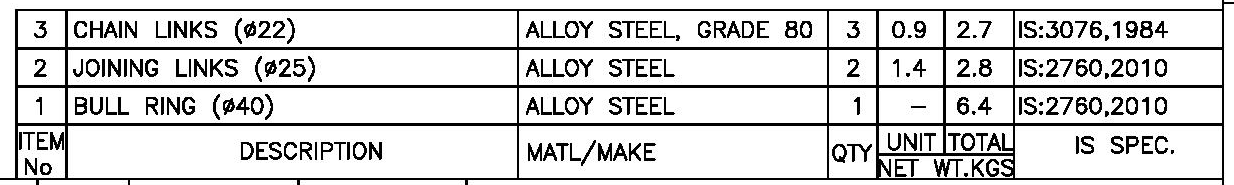

In [43]:
xx_gray_list = crop_bom(310)

for i in range(len(xx_gray_list)):
    
    print(xx_gray_list[i].shape)

    xx_pil = Image.fromarray(xx_gray_list[i])

    display(xx_pil)

In [65]:
xx_gray_list_0 = xx_gray_list[0][21:38, 244:256]
print(xx_gray_list_0.shape)
xx_pil = Image.fromarray(xx_gray_list_0)
display(xx_pil)

(17, 12)


In [66]:
xx_gray_list_0

array([[255, 250, 243, 254, 250, 255, 248, 253,   9,   0, 255, 250],
       [255, 255, 255, 255, 239, 255, 255, 254,  13,   3,   0, 255],
       [238, 255, 233, 246, 255, 253, 249,   0,   0,   0, 255, 255],
       [246, 255, 255,   0,   0,   2,   9,   0,   9,   0, 255, 246],
       [255, 243,   6,   6,   0,   0,   0,   8,   0,  21,   0, 248],
       [255,   1,   0,  10,   0, 255,   0,   4,   0,   0,   4,   0],
       [  0,   0,  11,   0, 255, 250,   0,   0,   3,   0,   0,   5],
       [ 16,   5,   0, 255, 255,   5,   0,  20, 245,   4,   0,   0],
       [  0,  10,   2, 244, 255,   0,  19,   0, 255, 252,  13,   1],
       [  1,   0,   1, 255,   0,  12,   0, 255, 255,   0,  14,   0],
       [  0,   0,   3, 242,   0,   3,  18, 255, 251,   5,   0,   3],
       [252,   9,   7,   6,   2,   0, 241, 249, 255,   5,   4,   0],
       [254,   0,   0,   0,   2,   9, 255,   0,  10,   4,   0,   0],
       [250, 255,   0,  15,   0,   4,   2,   0,  12,   0,   7, 255],
       [241, 255,   0,   4,   3,  

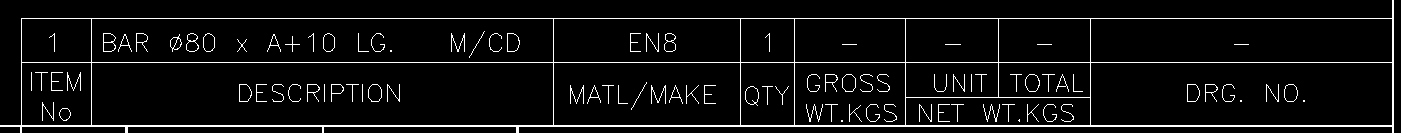

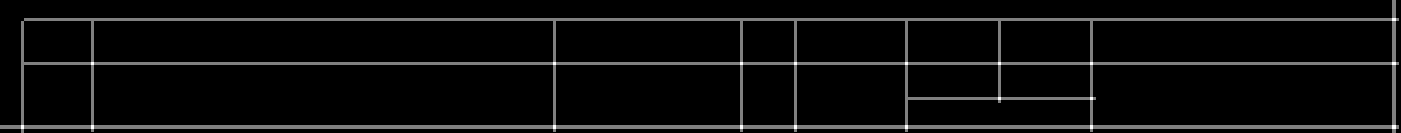

No. of columns =  8
width_frequency =  [1 1 1 1 1 1 1 1]
width list =  [301.  91.  92. 110.  53. 186. 461.  69.]
Row count =  1
No. of Items =  1


ITEM\nNo              DESCRIPTION MATL /MAKE QTY CROSS\nWTKGS UNIT TOTAL  \
0        1  BAR #80 x A+10 LG. M/CD        EN8   1                           

  DRC. NO.  
0

In [96]:
df = bom_df(320)

df.head(20)

In [29]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'],
                   kernel_initializer='he_normal',
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [31]:
from keras.initializers import he_normal

In [30]:
# 5/8 dropout

def make_yolov3_model_drop():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 62 => 65
##    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
##                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])


    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
     # Layer 66 => 74
##    for i in range(3):
##        x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
##                            {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 75 => 79
##    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
#    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
#                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = Dropout(0.2)(x)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103}], skip=False)
    x = Dropout(0.2)(x)

    # Layer 92 => 94
#    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
#                              {'filter':   18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
#    # Layer 95 => 980
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True,  'leaky': True,  'layer_idx': 93},
                              {'filter':   18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 94}], skip=False)


#    # Layer 99 => 106
#    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
#                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

    final = Reshape((grid_y_axis,grid_x_axis,3,6))(yolo_94)
    model = Model(input_image, final)
    return model


In [32]:
input_size = (target_w, target_h, 3)


my_model_1 = make_yolov3_model_drop()
my_model_2 = make_yolov3_model_drop()
my_model_3 = make_yolov3_model_drop()
my_model_4 = make_yolov3_model_drop()

print(my_model_1.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________